In [ ]:
#!pip install setuptools==65.5.0
#!pip install stable-baselines3
!pip install sb3-contrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Introduction
For this project, I experiment with reinforcement learning algorithms for portfolio optimization.   The goal of portfolio optimization is to maximize return on investment by balancing capital between a given number of portfolio assets. 

Portfolios are usually balanced infrequently, but due to the data requirements of reinforcement learning the model will be rebalancing its portfolio once every hour.  

Machine learning algorithms have intuitive real-world potential for algorithmic trading, as they are able to process data and react much faster than a human. 

First, I construct a reinforcement learning environment and provide the model with possible action choices to take at each timestep.  I will then compare the model's performance to an evenly weighted portfolio of the same assets. 

For the purposes of learning and so that I can focus on the coding aspects of the project, I am ignoring several real-world factors such as bid-ask spread and transaction fees.  

I am designing my environment under the assumption that the algorithm buys and sells each asset immediately before the end of the previous hour. 

This is a toy constructed for learning purposes.  There may be errors and it should not be expected to be truly competitive in a real-world scenario.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import gym
import random as rand
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import gym
from gym import spaces
import math
from pathlib import Path
import warnings
from sb3_contrib import TRPO
warnings.filterwarnings("ignore")

# Importing and cleaning data
**Included assets**
- Hourly stock data:  AMZN, COST, IBM, JNJ, JPM, XOM

- Hourly SP500 futures data, used as a market baseline for portfolio optimization calculations.  Included as a proxy for SP500 hourly index data.

- US Treasury 1-year yield, used here to calculate the riskless rate of return for portfolio optimization. 

I perform routine data cleaning on the asset DataFrames to enable easy merging.  I create a column for log-normalized daily returns and columns for volatility and variance, each over five days.  I perform similar data cleaning on the treasury yield DataFrame and convert the yearly treasury return to an estimated hourly treasury return, used for riskless rate.

In [ ]:
columnNames=['Date','Open','High','Low','Close','Volume']
AMZN=pd.read_csv('/content/drive/MyDrive/data/1_HR_HIST/amzn-1h.csv',sep=';',names=columnNames)
COST=pd.read_csv('/content/drive/MyDrive/data/1_HR_HIST/cost-1h.csv',sep=';',names=columnNames)
IBM=pd.read_csv('/content/drive/MyDrive/data/1_HR_HIST/ibm-1h.csv',sep=';',names=columnNames)
JNJ=pd.read_csv('/content/drive/MyDrive/data/1_HR_HIST/jnj-1h.csv',sep=';',names=columnNames)
JPM=pd.read_csv('/content/drive/MyDrive/data/1_HR_HIST/jpm-1h.csv',sep=';',names=columnNames)
XOM=pd.read_csv('/content/drive/MyDrive/data/1_HR_HIST/xom-1h.csv',sep=';',names=columnNames)
SPY=pd.read_csv('/content/drive/MyDrive/data/1_HR_HIST/es-1h.csv',sep=';',names=columnNames)
USGB=pd.read_excel('/content/drive/MyDrive/data/portfolio_index/USGB.xlsx')

In [ ]:
# For dataframe loops
assetList=[SPY,AMZN,COST,IBM,JNJ,JPM,XOM]
assetNames=['SPY','AMZN','COST','IBM','JNJ','JPM','XOM']

In [ ]:
# Cleaning the time column.  
# Creating arbitrary empty columns for volatility and variance to be added later.
newDFs=[]
for i in range(7):
  asset=assetList[i]
  assetName=assetNames[i]
  asset['Hour']=asset['Date']
  asset['Date']=asset.index
  asset['Year']=asset['Date'].str[-4:].astype(int)
  asset=asset.loc[asset['Year']>=2007]
  asset['Date']=asset[['Date','Hour']].agg('/'.join,axis=1)
  asset['Date']=asset['Date'].str[:-6]
  asset=asset.reset_index()
  asset[assetName+'-Close']=asset['Close']
  asset[assetName+'-LogRet']=np.log(asset['Close']/asset['Close'].shift())
  asset[assetName+'-Vol5H']=asset[assetName+'-LogRet']
  asset[assetName+'-Variance']=asset[assetName+'-LogRet']
  asset=asset[['Date',assetName+'-Close',assetName+'-LogRet',assetName+'-Vol5H',assetName+'-Variance']]
  newDFs.append(asset)

0
1
2
3
4
5
6


In [ ]:
# Overwriting individual asset DFs with cleaned DFs.
SPY,AMZN,COST,IBM,JNJ,JPM,XOM=newDFs[0],newDFs[1],newDFs[2],newDFs[3],newDFs[4],newDFs[5],newDFs[6]
assetList=[SPY,AMZN,COST,IBM,JNJ,JPM,XOM]

In [ ]:
# Function to calculate volatility and variance.  
def realizedVol(series):
  vol=series.std()*np.sqrt(len(series))
  var=vol**2
  return vol,var

In [ ]:
# Adding volatility and variance to DFs.
newDFsDFs=[]
for i in range(7):
  asset=assetList[i]
  assetName=assetNames[i]
  for i in range(6,len(asset)):
    series=asset.iloc[i-5:i,-3]
    var,vol=realizedVol(series.values)
    asset[assetName+'-Variance'].iloc[i]=var
    asset[assetName+'-Vol5H'].iloc[i]=vol
  newDFsDFs.append(asset)

In [ ]:
# Merging new DFs into one DF.
#allDF=newDFsDFs[0]
#for d in newDFsDFs[1:]:
#  allDF=pd.merge(allDF,d,on='Date')
#for asset in assetNames:
#  allDF[asset+'-PrevClose']=allDF[asset+'-Close'].shift(1)
#allDF
# Creating a backup of this DF.
#from pathlib import Path
filepath = Path('/content/drive/MyDrive/data/1_HR_HIST/allDFbase.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
#allDF.to_csv(filepath)  

allDF=pd.read_csv(filepath)
allDF=allDF.drop('Unnamed: 0',axis=1)

In [ ]:
# Rearranging order of DF columns. 
newColOrder=['Date','SPY-Close','AMZN-Close', 'COST-Close', 'IBM-Close',
             'JNJ-Close','JPM-Close','XOM-Close',
             'SPY-PrevClose','AMZN-PrevClose', 'COST-PrevClose', 'IBM-PrevClose',
             'JNJ-PrevClose','JPM-PrevClose','XOM-PrevClose',
             'SPY-LogRet','AMZN-LogRet', 'COST-LogRet','IBM-LogRet',
             'JNJ-LogRet','JPM-LogRet','XOM-LogRet',
             'SPY-Vol5H','AMZN-Vol5H', 'COST-Vol5H', 'IBM-Vol5H',   
             'JNJ-Vol5H', 'JPM-Vol5H', 'XOM-Vol5H','SPY-Variance']
allDF=allDF[newColOrder]
allDF

,Date,SPY-Close,AMZN-Close,COST-Close,IBM-Close,JNJ-Close,JPM-Close,XOM-Close,SPY-PrevClose,AMZN-PrevClose,...,JPM-LogRet,XOM-LogRet,SPY-Vol5H,AMZN-Vol5H,COST-Vol5H,IBM-Vol5H,JNJ-Vol5H,JPM-Vol5H,XOM-Vol5H,SPY-Variance
0,02/04/2007/09,1431.75,1.9919,39.3522,57.8397,38.5080,31.8013,40.5853,NaN,NaN,...,-0.006472,0.003465,1.500145e-06,0.000096,0.000055,0.000046,0.000016,0.000142,0.000085,0.001225
1,02/04/2007/10,1431.00,1.9869,39.2385,57.9092,38.4557,31.7149,40.6348,1431.75,1.9919,...,-0.002721,0.001219,1.060327e-06,0.000106,0.000063,0.000032,0.000015,0.000103,0.000039,0.001030
2,02/04/2007/11,1430.75,2.0003,39.2763,58.2723,38.4731,31.6806,40.7475,1431.00,1.9869,...,-0.001082,0.002770,1.194605e-06,0.000029,0.000068,0.000029,0.000011,0.000100,0.000034,0.001093
3,02/04/2007/12,1430.75,2.0013,39.2289,58.2416,38.4296,31.7840,40.8739,1430.75,2.0003,...,0.003259,0.003097,7.555869e-07,0.000051,0.000068,0.000051,0.000011,0.000057,0.000033,0.000869
4,02/04/2007/13,1432.00,2.0033,39.3619,58.2183,38.4731,31.7495,40.8529,1430.75,2.0013,...,-0.001086,-0.000514,2.072797e-07,0.000051,0.000047,0.000042,0.000008,0.000049,0.000029,0.000455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28151,06/04/2023/10,4121.25,100.6000,481.5600,130.8800,165.0100,127.6700,116.3400,4104.25,100.2739,...,0.002667,-0.004588,1.684663e-05,0.000072,0.001267,0.000041,0.000004,0.000016,0.000057,0.004104
28152,06/04/2023/11,4126.50,101.3950,485.0200,130.6800,165.5600,127.6600,116.3800,4121.25,100.6000,...,-0.000078,0.000344,3.343329e-05,0.000095,0.001458,0.000042,0.000068,0.000013,0.000076,0.005782
28153,06/04/2023/12,4129.00,101.3050,486.8500,131.0000,165.7100,127.6971,116.2400,4126.50,101.3950,...,0.000291,-0.001204,3.300630e-05,0.000151,0.001551,0.000027,0.000069,0.000013,0.000058,0.005745
28154,06/04/2023/13,4129.75,101.7100,485.4000,130.5348,166.0000,127.5950,116.3800,4129.00,101.3050,...,-0.000800,0.001204,2.065036e-05,0.000151,0.001600,0.000042,0.000068,0.000010,0.000052,0.004544


In [ ]:
# Cleaning USGB
USGB2=USGB[6:]
USGB2=USGB2.iloc[::-1]
USGB2=USGB2.rename(columns={'Security':'Date'})
USGB2['DailyRate']=((USGB2['USGB360D Index                                                  ']/100)).astype('float64')
USGB2['DailyRate']=100*((np.log(1+USGB2['DailyRate'])/255/7))
USGB2.index=USGB2['Date']
USGB2

,Date,USGB360D Index,DailyRate
Date,,,
2008-08-14,2008-08-14 00:00:00,2.03504,0.001129
2008-08-15,2008-08-15 00:00:00,2.03527,0.001129
2008-08-18,2008-08-18 00:00:00,1.99433,0.001106
2008-08-19,2008-08-19 00:00:00,1.95365,0.001084
2008-08-20,2008-08-20 00:00:00,1.93467,0.001073
...,...,...,...
2023-03-20,2023-03-20 00:00:00,4.21378,0.002312
2023-03-21,2023-03-21 00:00:00,4.27056,0.002343
2023-03-22,2023-03-22 00:00:00,4.18976,0.002299


In [ ]:
# Creating a temporary DF for normalizing the USGB date to match asset hourly dates.
# Using this resultant 'Date' column to merge with allDF.
df=pd.DataFrame()
df.index=pd.date_range('2008-08-14','2023-03-24',freq='H')
df['Date']=df.index.date
df['Rate']=USGB2['DailyRate']
df=df.fillna(method='ffill', downcast='infer')
#df.index=pd.to_datetime(df.index,format='%d/%m/%Y/%H')
df['Date']=df['Date'].astype(str)
df['Year']=df['Date'].str[:4]
df['x']=df.index.astype(str)
df['Hour']=df['x'].str[11:13]
df['Day']=df['Date'].str[-2:]
df['Month']=df['Date'].str[5:7]
df['Date']=df['Day']+'/'+df['Month']+'/'+df['Year']+'/'+df['Hour']
df=df.reset_index()
df=df[['Date','Rate']]
allDF=pd.merge(allDF,df,on='Date')
allDF

,Date,SPY-Close,AMZN-Close,COST-Close,IBM-Close,JNJ-Close,JPM-Close,XOM-Close,SPY-PrevClose,AMZN-PrevClose,...,XOM-LogRet,SPY-Vol5H,AMZN-Vol5H,COST-Vol5H,IBM-Vol5H,JNJ-Vol5H,JPM-Vol5H,XOM-Vol5H,SPY-Variance,Rate
0,14/08/2008/09,1291.50,4.3169,49.5870,78.6554,47.1187,25.9249,42.7034,1284.75,4.3304,...,-0.007224,0.000083,0.001014,0.000303,0.000135,0.000027,0.000736,0.000081,0.009091,0.001129
1,14/08/2008/10,1293.75,4.3653,49.7769,79.8999,47.1972,26.2780,42.9851,1291.50,4.3169,...,0.006575,0.000133,0.000576,0.000217,0.000152,0.000018,0.000656,0.000116,0.011517,0.001129
2,14/08/2008/11,1298.00,4.3748,50.0715,80.2554,47.3711,26.3729,42.8653,1293.75,4.3653,...,-0.002791,0.000133,0.000623,0.000223,0.000353,0.000018,0.000721,0.000161,0.011553,0.001129
3,14/08/2008/12,1295.25,4.4197,50.4893,80.2865,47.4932,26.6312,42.5205,1298.00,4.3748,...,-0.008076,0.000137,0.000606,0.000217,0.000349,0.000024,0.000713,0.000138,0.011696,0.001129
4,14/08/2008/13,1291.25,4.4017,50.1473,80.1551,47.2841,26.4505,42.7176,1295.25,4.4197,...,0.004625,0.000044,0.000370,0.000196,0.000334,0.000026,0.000702,0.000152,0.006661,0.001129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25676,23/03/2023/11,4014.00,100.4499,492.1100,124.5890,150.8500,127.4100,105.7500,4027.00,100.8270,...,-0.001134,0.000040,0.000544,0.000189,0.000279,0.000075,0.000465,0.000332,0.006322,0.002243
25677,23/03/2023/12,3994.00,100.1850,490.7250,124.3914,151.4850,127.1520,104.6500,4014.00,100.4499,...,-0.010456,0.000063,0.000529,0.000189,0.000282,0.000071,0.000462,0.000332,0.007922,0.002243
25678,23/03/2023/13,3968.00,99.3642,490.9214,123.9800,151.2800,126.2888,103.8700,3994.00,100.1850,...,-0.007481,0.000093,0.000525,0.000193,0.000279,0.000100,0.000455,0.000398,0.009642,0.002243
25679,23/03/2023/14,3975.75,98.3400,486.0600,123.2200,150.7750,125.6637,102.9500,3968.00,99.3642,...,-0.008897,0.000101,0.000313,0.000061,0.000105,0.000022,0.000223,0.000235,0.010036,0.002243


# Performing portfolio optimization calculations
I calculate asset betas and use that to derive a value for expected rate of return.  I then experiment with a few naive portfolio optimization equations including the Sharpe ratio, maximum diversification, and minimum variance. 

Since it takes a long time to iterate over approximately 26,000 rows for each of these methods, I save the portfolio weights generated by each method as an Excel sheet.

In [ ]:
# Creating a beta dataframe to perform expected return calculations with. 
betaDF=allDF[['SPY-LogRet','AMZN-LogRet', 'COST-LogRet','IBM-LogRet',
             'JNJ-LogRet','JPM-LogRet','XOM-LogRet','SPY-Variance',
              'AMZN-Vol5H','COST-Vol5H','IBM-Vol5H','JNJ-Vol5H','XOM-Vol5H',
              'JPM-Vol5H','Rate']]
etfList=['AMZN','COST','IBM','JNJ','JPM','XOM']
for etf in etfList:
  dfCov=betaDF[[etf+'-LogRet','SPY-LogRet']].rolling(5).cov().unstack()
  betaDF[etf+'-cov']=dfCov['SPY-LogRet'][etf+'-LogRet'];
for etf in etfList:
  betaDF[etf+'-beta']=100*betaDF[etf+'-cov']/betaDF['SPY-Variance']
betaDF

,SPY-LogRet,AMZN-LogRet,COST-LogRet,IBM-LogRet,JNJ-LogRet,JPM-LogRet,XOM-LogRet,SPY-Variance,AMZN-Vol5H,COST-Vol5H,...,IBM-cov,JNJ-cov,JPM-cov,XOM-cov,AMZN-beta,COST-beta,IBM-beta,JNJ-beta,JPM-beta,XOM-beta
0,0.006993,-0.003122,-0.003822,-0.005100,0.000743,0.010025,-0.007224,0.009091,0.001014,0.000303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001741,0.011149,0.003822,0.015698,0.001665,0.013528,0.006575,0.011517,0.000576,0.000217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.003280,0.002174,0.005901,0.004439,0.003678,0.003605,-0.002791,0.011553,0.000623,0.000223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.002121,0.010211,0.008309,0.000387,0.002574,0.009746,-0.008076,0.011696,0.000606,0.000217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.003093,-0.004081,-0.006797,-0.001638,-0.004412,-0.006808,0.004625,0.006661,0.000370,0.000196,...,-2.071598e-06,0.000006,0.000016,-0.000009,-0.099616,-0.027798,-0.031102,0.084706,0.243727,-0.135229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25676,-0.003233,-0.003747,-0.001401,-0.000169,-0.000994,-0.002295,-0.001134,0.006322,0.000544,0.000189,...,-1.518700e-05,-0.000013,0.000011,0.000004,0.465311,0.111307,-0.240222,-0.199515,0.171957,0.059764
25677,-0.004995,-0.002641,-0.002818,-0.001587,0.004201,-0.002027,-0.010456,0.007922,0.000529,0.000189,...,-9.912670e-06,-0.000009,0.000021,0.000020,0.261070,0.092620,-0.125130,-0.110122,0.262836,0.249051
25678,-0.006531,-0.008227,0.000400,-0.003313,-0.001354,-0.006812,-0.007481,0.009642,0.000525,0.000193,...,-8.692654e-07,-0.000003,0.000036,0.000033,0.417848,0.128835,-0.009015,-0.035983,0.377256,0.344244
25679,0.001951,-0.010361,-0.009952,-0.006149,-0.003344,-0.004962,-0.008897,0.010036,0.000313,0.000061,...,7.762302e-07,-0.000005,0.000002,0.000005,0.016011,-0.073258,0.007735,-0.045092,0.016198,0.048987


In [ ]:
# Creating individual DFs for variable categories across stocks, for 
# easy access later. 
priceDF=allDF[['AMZN-Close', 'COST-Close', 'IBM-Close','JNJ-Close', 'JPM-Close', 'XOM-Close']]
logReturnsDF=allDF[['AMZN-LogRet','COST-LogRet', 'IBM-LogRet', 'JNJ-LogRet', 'JPM-LogRet', 'XOM-LogRet']]
realizedVolDF=allDF[['AMZN-Vol5H', 'COST-Vol5H', 'IBM-Vol5H', 'JNJ-Vol5H','JPM-Vol5H', 'XOM-Vol5H']]

In [ ]:
# Creating an expected return DF and performing ER calculations using beta. 
expReturns=allDF[['SPY-Close','IBM-Close']]
expReturns['SPY']=allDF['SPY-Close'].pct_change(periods=5)
expReturns['AMZN-ExR']=betaDF['Rate']+betaDF['AMZN-beta']*(expReturns['SPY']-betaDF['Rate'])
expReturns['COST-ExR']=betaDF['Rate']+betaDF['COST-beta']*(expReturns['SPY']-betaDF['Rate'])
expReturns['IBM-ExR']=betaDF['Rate']+betaDF['IBM-beta']*(expReturns['SPY']-betaDF['Rate'])
expReturns['JNJ-ExR']=betaDF['Rate']+betaDF['JNJ-beta']*(expReturns['SPY']-betaDF['Rate'])
expReturns['JPM-ExR']=betaDF['Rate']+betaDF['JPM-beta']*(expReturns['SPY']-betaDF['Rate'])
expReturns['XOM-ExR']=betaDF['Rate']+betaDF['XOM-beta']*(expReturns['SPY']-betaDF['Rate'])
# Adding volatility to ER DF.
volList=['AMZN-Vol5H','COST-Vol5H','IBM-Vol5H','JNJ-Vol5H',
         'JPM-Vol5H','XOM-Vol5H']
for column in volList:
  expReturns[column]=allDF[column]
# Dropping unneeded columns.
expReturns=expReturns.drop(columns=['SPY-Close','IBM-Close'],axis=1)
expReturns

,SPY,AMZN-ExR,COST-ExR,IBM-ExR,JNJ-ExR,JPM-ExR,XOM-ExR,AMZN-Vol5H,COST-Vol5H,IBM-Vol5H,JNJ-Vol5H,JPM-Vol5H,XOM-Vol5H
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001014,0.000303,0.000135,0.000027,0.000736,0.000081
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000576,0.000217,0.000152,0.000018,0.000656,0.000116
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000623,0.000223,0.000353,0.000018,0.000721,0.000161
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000606,0.000217,0.000349,0.000024,0.000713,0.000138
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000370,0.000196,0.000334,0.000026,0.000702,0.000152
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25676,-0.004958,-0.001108,0.001442,0.003973,0.003680,0.001005,0.001813,0.000544,0.000189,0.000279,0.000075,0.000465,0.000332
25677,0.006299,0.003302,0.002619,0.001736,0.001797,0.003309,0.003253,0.000529,0.000189,0.000282,0.000071,0.000462,0.000332
25678,-0.000944,0.000911,0.001833,0.002272,0.002358,0.001041,0.001146,0.000525,0.000193,0.000279,0.000100,0.000455,0.000398
25679,-0.013645,0.001989,0.003407,0.002120,0.002960,0.001986,0.001465,0.000313,0.000061,0.000105,0.000022,0.000223,0.000235


In [ ]:
# Cleaner versions of the above DFs.
expReturnsDF=expReturns[['AMZN-ExR', 'COST-ExR', 'IBM-ExR', 'JNJ-ExR', 'JPM-ExR','XOM-ExR']]
for column in ['AMZN-ExR', 'COST-ExR', 'IBM-ExR', 'JNJ-ExR', 'JPM-ExR','XOM-ExR']:
  expReturnsDF[column]=expReturnsDF[column]
for column in ['AMZN-LogRet','COST-LogRet', 'IBM-LogRet', 'JNJ-LogRet', 'JPM-LogRet', 'XOM-LogRet']:
  logReturnsDF[column]=logReturnsDF[column]
# Dropping the first five values of all DFs.  
# This should remove all NaNs while ensuring orders and lengths don't become mismatched.
logReturnsDF=logReturnsDF[5:]
priceDF=priceDF[5:]
realizedVolDF=realizedVolDF[5:]
allDF=allDF[5:]
expReturnsDF=expReturnsDF[5:]
# Verifying that DF lengths match.
len(allDF),len(logReturnsDF),len(priceDF),len(realizedVolDF),len(expReturnsDF)

(25676, 25676, 25676, 25676, 25676)

In [ ]:
# Maximum diversification portfolio weight
def testPortfolioWeightsMaxDivers(i):
  portfolioReturns=[]
  portfolioVolatilities=[]
  portfolioWeights=[]
  portfolioTestCount=100
  for i in range(portfolioTestCount-1):
    weights=np.random.random(6)
    weights=weights/np.sum(weights)
    portfolioWeights.append(weights)
    portfolioReturn=np.mean(realizedVolDF.iloc[i-5:i,:])
    returns=np.dot(weights,portfolioReturn)
    portfolioReturns.append(returns)
    covMatrix=logReturnsDF.iloc[i-5:i,:].cov()
    P_ret=returns
    P_vol=np.sqrt(np.dot(weights.T,np.dot(covMatrix,weights)))
    portfolioVolatilities.append(P_vol)
  dfWeights=pd.DataFrame(portfolioWeights,columns=['AMZN-w','COST-w','IBM-w','JNJ-w','JPM-w','XOM-w'])
  rf=betaDF['Rate'].iloc[i]
  df=pd.DataFrame()
  df['Portfolio-r']=portfolioReturns
  df['Portfolio-v']=portfolioVolatilities
  df['Portfolio-s']=(df['Portfolio-r']-rf)/df['Portfolio-v']
  df=pd.concat([df,dfWeights],axis=1)
  return df.dropna()
np.seterr(all='ignore')
testPortfolioWeightsMaxDivers(0)

,Portfolio-r,Portfolio-v,Portfolio-s,AMZN-w,COST-w,IBM-w,JNJ-w,JPM-w,XOM-w
5,0.000213,0.002529,-0.347026,0.198214,0.024114,0.287898,0.040128,0.152402,0.297243
6,0.000281,0.002018,-0.401272,0.231903,0.218060,0.207761,0.001951,0.238536,0.101789
7,0.000206,0.001316,-0.671929,0.025130,0.240792,0.275056,0.092435,0.155381,0.211206
8,0.000202,0.001317,-0.674868,0.123530,0.117380,0.257209,0.175080,0.207609,0.119193
9,0.000127,0.001868,-0.515867,0.121656,0.070501,0.320288,0.313661,0.155272,0.018621
...,...,...,...,...,...,...,...,...,...
94,0.000192,0.005164,-0.174002,0.030558,0.033739,0.337546,0.291655,0.068722,0.237780
95,0.000173,0.005204,-0.176271,0.146319,0.127440,0.242641,0.341616,0.068723,0.073261
96,0.000206,0.005158,-0.171448,0.167552,0.080780,0.293804,0.199426,0.148951,0.109487
97,0.000184,0.004499,-0.201569,0.249511,0.144935,0.314863,0.135506,0.032620,0.122565


In [ ]:
# Sharpe ratio portfolio weights
def testPortfolioWeights(i):
  portfolioReturns=[]
  portfolioVolatilities=[]
  portfolioWeights=[]
  portfolioTestCount=100
  calcVol=realizedVolDF.iloc[i-5:i,:]
  for i in range(portfolioTestCount-1):
    weights=np.random.random(6)
    weights=weights/np.sum(weights)
    portfolioWeights.append(weights)
    portfolioReturn=expReturnsDF.iloc[i,:]
    returns=np.dot(weights,portfolioReturn)
    portfolioReturns.append(returns)
    covMatrix=logReturnsDF.iloc[i-5:i,:].cov()
    P_ret=returns
    P_vol=np.sqrt(np.dot(weights.T,np.dot(covMatrix,weights)))
    portfolioVolatilities.append(P_vol)
  dfWeights=pd.DataFrame(portfolioWeights,columns=['ARKK-w','GLD-w','R2K-w','QQQ-w','XLE-w','BND-w'])
  rf=betaDF['Rate'].iloc[i]
  df=pd.DataFrame()
  df['Portfolio-r']=portfolioReturns
  df['Portfolio-v']=portfolioVolatilities
  df['Portfolio-s']=(df['Portfolio-r']-rf)/df['Portfolio-v']
  df=pd.concat([df,dfWeights],axis=1)
  return df.dropna()
np.seterr(all='ignore')
testPortfolioWeights(10)

,Portfolio-r,Portfolio-v,Portfolio-s,ARKK-w,GLD-w,R2K-w,QQQ-w,XLE-w,BND-w
5,0.001307,0.004780,0.045240,0.271099,0.188087,0.092599,0.055899,0.338326,0.053990
6,0.001126,0.002157,0.016404,0.046860,0.045929,0.162451,0.110429,0.283032,0.351299
7,0.001173,0.001313,0.062420,0.222072,0.255532,0.135871,0.154437,0.151727,0.080360
8,0.001114,0.000902,0.026127,0.195363,0.250143,0.167352,0.281169,0.085689,0.020284
9,0.001128,0.003042,0.012269,0.079108,0.188846,0.173187,0.185526,0.297471,0.075862
...,...,...,...,...,...,...,...,...,...
94,-0.001196,0.004507,-0.507333,0.319592,0.274602,0.094317,0.092264,0.094004,0.125221
95,-0.002327,0.005269,-0.648593,0.009002,0.218590,0.100492,0.350176,0.080361,0.241379
96,-0.004911,0.004781,-1.255422,0.084785,0.285929,0.124868,0.238510,0.074268,0.191641
97,-0.001786,0.006728,-0.427610,0.073965,0.194392,0.312958,0.029358,0.348649,0.040678


In [ ]:
# Finds best maximimum diversification weights for a timestep.
def findMaxDiversAndWeights(i):
  df=testPortfolioWeightsMaxDivers(i)
  best=df.loc[df['Portfolio-s'].idxmin()]
  P_ret,P_vol=best[0],best[1]
  weights=best[3:].tolist()
  sharpe=P_ret/P_vol
  return sharpe,weights,P_ret
findMaxDiversAndWeights(5)

(0.12638967042418126,
 [0.22528863940541052,
  0.2596469962970152,
  0.09273917699806537,
  0.10011642920867163,
  0.025285411404551556,
  0.2969233466862858],
 0.00010410257149274405)

In [ ]:
# Finds best Sharpe weights for a timestep. 
def findSharpeAndWeights(i):
  df=testPortfolioWeights(i)
  best=df.loc[df['Portfolio-s'].idxmax()]
  P_ret,P_vol=best[0],best[1]
  weights=best[3:].tolist()
  sharpe=P_ret/P_vol
  return sharpe,weights,P_ret
findSharpeAndWeights(5)

(1.3543834738053058,
 [0.22137754357742986,
  0.22560937442985987,
  0.10612949404865259,
  0.13888849526466046,
  0.010652862048460455,
  0.29734223063093684],
 0.001740374605853362)

In [ ]:
# Finds best minimum variance weights for a timestep. 
def findMarkAndWeights(i):
  df=testPortfolioWeights(i)
  best=df.loc[df['Portfolio-v'].idxmin()]
  P_ret,P_vol=best[0],best[1]
  weights=best[3:].tolist()
  sharpe=P_ret/P_vol
  return sharpe,weights,P_ret
findMarkAndWeights(5)

(1.3929084266032183,
 [0.37984512537341436,
  0.037875511743807544,
  0.04782819166903556,
  0.2425693320603134,
  0.09766619770951958,
  0.1942156414439095],
 0.00109571613704951)

In [ ]:
# Iterates through DF and finds maxDiv weights for all timesteps. 
# Saves as a CSV.
#maxDiversList=[]
#for i in range(len(expReturnsDF)):
#  sharpe,maxDivWeights,P_ret=findMaxDiversAndWeights(i)
#  maxDiversList.append(maxDivWeights)
#  if i%100==0:
#    print(i)
#maxDivDF=pd.DataFrame(maxDiversList)
filepath = Path('/content/drive/MyDrive/data/1_HR_HIST/maxDivDFbase.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
#maxDivDF.to_csv(filepath) 

maxDivDF=pd.read_csv('/content/drive/MyDrive/data/1_HR_HIST/maxDivDFbase.csv')
maxDivDF=maxDivDF.drop('Unnamed: 0',axis=1)
maxDivDF

,0,1,2,3,4,5
0,0.248731,0.194059,0.086249,0.368877,0.042667,0.059418
1,0.172350,0.135341,0.334991,0.038925,0.047634,0.270759
2,0.264852,0.051676,0.274467,0.221439,0.052790,0.134776
3,0.336555,0.183570,0.072846,0.189648,0.001701,0.215681
4,0.345794,0.278438,0.132455,0.149171,0.038776,0.055366
...,...,...,...,...,...,...
25671,0.117287,0.122051,0.165484,0.263360,0.054333,0.277486
25672,0.090041,0.215857,0.241372,0.171895,0.052265,0.228570
25673,0.181441,0.141003,0.030837,0.344010,0.110999,0.191710
25674,0.155087,0.340009,0.109987,0.332755,0.042260,0.019902


In [ ]:
# Iterates through a DF and finds best Sharpe weights for all timesteps.
# Saves as a CSV.

#sharpeList=[]
#for i in range(len(expReturnsDF)):
#  sharpe,sharpeWeights,P_ret=findSharpeAndWeights(i)
#  sharpeList.append(sharpeWeights)
#  if i%100==0:
#    print(i)
#sharpeDF=pd.DataFrame(sharpeList)
#filepath = Path('/content/drive/MyDrive/data/1_HR_HIST/sharpeDFbase.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
#sharpeDF.to_csv(filepath) 
sharpeDF=pd.read_csv('/content/drive/MyDrive/data/1_HR_HIST/sharpeDFbase3.csv')
sharpeDF=sharpeDF.drop('Unnamed: 0',axis=1)
sharpeDF

,0,1,2,3,4,5
0,0.272398,0.043547,0.050844,0.180191,0.151820,0.301201
1,0.190645,0.068733,0.220573,0.049993,0.155849,0.314207
2,0.164103,0.424062,0.123546,0.039510,0.205638,0.043143
3,0.264084,0.083208,0.222926,0.117368,0.175258,0.137156
4,0.259681,0.230506,0.137568,0.183654,0.046434,0.142157
...,...,...,...,...,...,...
25671,0.179975,0.244190,0.054616,0.041729,0.092517,0.386973
25672,0.211732,0.196250,0.182911,0.169769,0.149972,0.089365
25673,0.371890,0.144795,0.071690,0.000687,0.088252,0.322685
25674,0.078754,0.207314,0.226894,0.081608,0.119493,0.285937


In [ ]:
# Iterates through a DF and finds best minimum variance weights for a timestep.
# Saves as a CSV.

#markList=[]
#for i in range(len(expReturnsDF)):
#  mark,markWeights,P_ret=findMarkAndWeights(i)
#  markList.append(markWeights)
#  if i%100==0:
#    print(i)
#markDF=pd.DataFrame(markList)
filepath = Path('/content/drive/MyDrive/data/1_HR_HIST/markDFbaseLOWRISK.csv')
#filepath.parent.mkdir(parents=True, exist_ok=True)  
#markDF.to_csv(filepath)
 
markDF=pd.read_csv(filepath)
markDF=markDF.drop('Unnamed: 0',axis=1)
markDF

,0,1,2,3,4,5
0,0.224567,0.144007,0.229205,0.309387,0.019723,0.073111
1,0.199000,0.069814,0.218596,0.058646,0.176145,0.277799
2,0.044039,0.239683,0.106389,0.235406,0.095858,0.278625
3,0.255954,0.250864,0.133761,0.050440,0.202183,0.106799
4,0.129574,0.144860,0.071779,0.458131,0.039896,0.155758
...,...,...,...,...,...,...
25671,0.210694,0.150036,0.141741,0.213254,0.144350,0.139924
25672,0.021058,0.237733,0.634917,0.019120,0.031827,0.055345
25673,0.233000,0.161718,0.095684,0.103046,0.262822,0.143730
25674,0.248432,0.299195,0.113901,0.116754,0.221230,0.000490


# Reinforcement learning

First, I create a train-test split using the above data.  I then construct the RL trading environment.  The model will choose between different optimization strategies as its action choices.  

During crude early experimentation, I gave the model action options such as 'wait and do nothing for a timestep', 'select random weights', and 'sell all assets and convert to cash for a round'.  

These performed poorly enough that the model never chose them, so I will experiment with portfolio methods instead. 

A balanced portfolio, with 1/6th of its funds in each asset constant across the timespace, will be used as a naive baselines.  

In [ ]:
#allDF=allDF.drop('Date',axis=1)
all_train,all_test,price_train,price_test,log_return_train,log_return_test,vol_train,vol_test,sharpe_train,sharpe_test,mark_train,mark_test,maxDiv_train,maxDiv_test=train_test_split(allDF,priceDF,logReturnsDF,realizedVolDF,sharpeDF,markDF,maxDivDF,shuffle=False)
all_test #2019-07-30 to 2023-03-23
3948.72/3013.18

1.3104826130533191

In [ ]:
class train_env(gym.Env):
  """Custom Environment that follows gym interface"""
  #metadata = {'render.modes': ['human']}
  def __init__(self,all,price,realizedVol,sharpe,mark):
    #super(train_env, self).__init__()
    self.all_train=all
    self.price_train=price
    self.vol_train=realizedVol
    self.sharpe_train=sharpe
    self.mark_train=mark

    self.netWorthHistory=[100]
    self.unweightedWorthHistory=[100]
    self.sharpeNWWorthHistory=[100]
    self.markNWWorthHistory=[100]

    self.actionHistory=[]
    self.action1ct=0
    self.action2ct=0
    self.action3ct=0

    self.day=5
    self.observations=np.array(self.all_train.iloc[self.day-1],dtype=np.float32)
    self.action_space = spaces.Discrete(2) #0, 1, 2

    self.observation_space=spaces.Box(low=-np.inf,high=np.inf,shape=[30])
    self.reward=0
    self.net_worth=100
    self.even_net_worth=100
    self.sharpe_net_worth=100
    self.mark_net_worth=100

    self.weights=[1/6 for i in range(6)]
    self.even_weights=[1/6 for i in range(6)]
    self.sharpeWeights=self.sharpe_train.iloc[self.day].values.tolist()
    self.markWeights=self.mark_train.iloc[self.day].values.tolist()

    self.volatility=self.vol_train.iloc[self.day-1].values.tolist()

    self.previous_prices=self.price_train.iloc[self.day-1].values.tolist()
    self.current_prices=self.price_train.iloc[self.day].values.tolist()

    self.previous_shares=self.weightsToShares(self.weights,self.net_worth)
    self.shares=self.weightsToShares(self.weights,self.net_worth)
    self.even_shares=self.weightsToShares(self.even_weights,self.net_worth)

    self.previous_asset_values=[self.previous_shares[i]*self.current_prices[i] for i in range(6)]
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]

    self.sharpeShares=self.weightsToShares(self.sharpeWeights,self.sharpe_net_worth)
    self.current_sharpe_assets=[self.current_prices[i]*self.sharpeShares[i] for i in range(6)]
    self.sharpe_net_worth=np.sum(self.current_sharpe_assets)
    self.sharpeNWWorthHistory.append(self.sharpe_net_worth)

    self.markShares=self.weightsToShares(self.markWeights,self.mark_net_worth)
    self.current_mark_assets=[self.current_prices[i]*self.markShares[i] for i in range(6)]
    self.mark_net_worth=np.sum(self.current_mark_assets)
    self.markNWWorthHistory.append(self.mark_net_worth)

    self.state=[self.net_worth]+self.shares+self.previous_prices+self.weights+self.volatility
    self.action=self.get_action()
    #self.net_worth=0,self.shares=[1:8],self.asset_values=[8:15],self.weights=[15:22]
    self.reset()
    self.step(self.action)

  def reset(self):
    # Reset the state of the environment to an initial state
    self.netWorthHistory=[100]
    self.unweightedWorthHistory=[100]
    self.sharpeNWWorthHistory=[100]
    self.markNWWorthHistory=[100]

    self.actionHistory=[]
    self.action1ct=0
    self.action2ct=0
    self.action3ct=0

    self.day=5
    self.observations=np.array(self.all_train.iloc[self.day-1],dtype=np.float32)
    self.action_space = spaces.Discrete(2) #0, 1, 2

    self.observation_space=spaces.Box(low=-np.inf,high=np.inf,shape=[30])
    self.reward=0
    self.net_worth=100
    self.even_net_worth=100
    self.sharpe_net_worth=100
    self.mark_net_worth=100

    self.weights=[1/6 for i in range(6)]
    self.even_weights=[1/6 for i in range(6)]

    self.sharpeWeights=self.sharpe_train.iloc[self.day].values.tolist()
    self.markWeights=self.mark_train.iloc[self.day].values.tolist()
    self.volatility=self.vol_train.iloc[self.day-1].values.tolist()

    self.previous_prices=self.price_train.iloc[self.day-1].values.tolist()
    self.current_prices=self.price_train.iloc[self.day].values.tolist()

    self.previous_asset_values=[self.previous_shares[i]*self.current_prices[i] for i in range(6)]
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]

    self.sharpeShares=self.weightsToShares(self.sharpeWeights,self.sharpe_net_worth)
    self.current_sharpe_assets=[self.current_prices[i]*self.sharpeShares[i] for i in range(6)]
    self.sharpe_net_worth=np.sum(self.current_sharpe_assets)
    self.sharpeNWWorthHistory.append(self.sharpe_net_worth)

    self.markShares=self.weightsToShares(self.markWeights,self.mark_net_worth)
    self.current_mark_assets=[self.current_prices[i]*self.markShares[i] for i in range(6)]
    self.mark_net_worth=np.sum(self.current_mark_assets)
    self.markNWWorthHistory.append(self.mark_net_worth)


    self.state=[self.net_worth]+self.shares+self.previous_prices+self.weights+self.volatility
    self.action=self.get_action()
    return self.nextObservations()

  def step(self,action):
    self.done=(self.day>=len(self.all_train)-1)
    if self.done:
      return self.state,self.reward,self.done, {'info':1}
    else:
      self.take_action(action)
      self.day+=1

      self.volatility=self.vol_train.iloc[self.day-1].values.tolist()
      self.previous_prices=self.price_train.iloc[self.day-1].values.tolist()
      self.current_prices=self.price_train.iloc[self.day].values.tolist()

      self.sharpeWeights=self.sharpe_train.iloc[self.day].values.tolist()
      self.sharpeShares=self.weightsToShares(self.sharpeWeights,self.sharpe_net_worth)
      self.current_sharpe_assets=[self.current_prices[i]*self.sharpeShares[i] for i in range(6)]
      self.sharpe_net_worth=np.sum(self.current_sharpe_assets)
      self.sharpeNWWorthHistory.append(self.sharpe_net_worth)

      self.markWeights=self.mark_train.iloc[self.day].values.tolist()
      self.markShares=self.weightsToShares(self.markWeights,self.mark_net_worth)
      self.current_mark_assets=[self.current_prices[i]*self.markShares[i] for i in range(6)]
      self.mark_net_worth=np.sum(self.current_mark_assets)
      self.markNWWorthHistory.append(self.mark_net_worth)

      self.even_shares=self.weightsToShares([1/6 for i in range(6)],self.even_net_worth)
      self.current_even_assets=[self.current_prices[i]*self.even_shares[i] for i in range(6)]
      self.even_net_worth=np.sum(self.current_even_assets)
      self.unweightedWorthHistory.append(self.even_net_worth)


      self.state=[self.net_worth]+self.shares+self.previous_prices+self.weights+self.volatility
      #self.current_prices=self.price_train.iloc[self.day].values.tolist()
      self.action=self.get_action()
      #self.asset_values=[self.weights[i]*self.net_worth for i in range(6)]
      return self.nextObservations(), self.reward, self.done, {'info':1}

  def nextObservations(self):
    day=self.day
    frame=np.array(self.all_train.iloc[day-1],dtype=np.float32)
    return frame

  def weightsToShares(self,weights1,net_worth):
    weightsValue=[net_worth*weights1[i] for i in range(6)]
    shares=[weightsValue[i]/self.previous_prices[i] for i in range(6)]
    return shares 

  def shareChangeToReward(self,newShares,action_type):

    self.previous_asset_values=np.sum([newShares[i]*self.previous_prices[i] for i in range(6)])
    self.shares=newShares
    self.asset_values=[self.shares[i]*self.current_prices[i] for i in range(6)]
    self.market_diff=np.sum(self.current_prices)/np.sum(self.previous_prices)
    self.portfolio_diff=(np.sum(self.asset_values))/np.sum(self.previous_asset_values)


    #if action_type==1:
      #altMshares=self.weightsToShares(self.markWeights,self.net_worth)
      #prevMvalues=np.sum([altMshares[i]*self.previous_prices[i] for i in range(6)])
      #Mvalues=np.sum([altMshares[i]*self.current_prices[i] for i in range(6)])
      #Mportfolio_diff=(np.sum(Mvalues)/np.sum(prevMvalues))
      #if Mportfolio_diff/self.portfolio_diff > 1.00:
        #if Mportfolio_diff>1:
          #diff=0.1*(1-np.abs(Mportfolio_diff))
          #self.portfolio_diff=self.portfolio_diff+diff
        #else:
          #self.portfolio_diff=self.portfolio_diff-1+np.abs(Mportfolio_diff)

    #if action_type==0:
      #altSshares=self.weightsToShares(self.sharpeWeights,self.net_worth)
      #prevSvalues=np.sum([altSshares[i]*self.previous_prices[i] for i in range(6)])
      #Svalues=np.sum([altSshares[i]*self.current_prices[i] for i in range(6)])
      #Sportfolio_diff=(np.sum(Svalues)/np.sum(prevSvalues))
      #if self.portfolio_diff/Sportfolio_diff>1.00:
        #if Sportfolio_diff>1:
          #self.portfolio_diff=self.portfolio_diff-1+np.abs(Sportfolio_diff)
        #else:
          #self.portfolio_diff=self.portfolio_diff+1-np.abs(Sportfolio_diff)

    self.reward=self.portfolio_diff-self.market_diff
    #self.net_worth=self.reward*self.net_worth
    self.net_worth=np.sum(self.asset_values)

    self.netWorthHistory.append(np.sum(self.asset_values))
    return self.reward

  def take_action(self,action):
    action_type=action
    self.actionHistory.append(action)
    if action_type==1:
      self.sharpeWeights=self.sharpe_train.iloc[self.day].values.tolist()
      self.shares=self.weightsToShares(self.sharpeWeights,self.net_worth)
      self.shareChangeToReward(self.shares,action_type)
      self.weights=self.sharpeWeights
      self.action1ct+=1
      return self.reward

    else:
      self.markWeights=self.mark_train.iloc[self.day].values.tolist()
      self.shares=self.weightsToShares(self.markWeights,self.net_worth)
      self.shareChangeToReward(self.shares,action_type)
      self.weights=self.markWeights
      env.action2ct+=1
  
      return self.reward

  def get_action(self):
    #action=1
    #action=rand.randint(0,2) 
    #return action
    pass

# PPO model
## Iterating over 50,000 training steps
This is equivalent to approximately two loops of the training data.

In [ ]:
env=train_env(all_train,price_train,vol_train,sharpe_train,maxDiv_train)
env.reset()
#env.step(env.action_space.sample())
PPOmodel = PPO('MlpPolicy', env, verbose=1)
PPOmodel.learn(total_timesteps=50000)
print(env.reward,env.net_worth)
print(env.action1ct,env.action2ct,env.action3ct)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 685  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 517         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017972764 |
|    clip_fraction        | 0.059       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.679      |
|    explained_variance   | 0.358       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0312      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00376    |
|    value_loss         

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
PPOrewardList=[]
PPOunweightedRewardList=[]
PPOsharpeRewardList=[]
PPOmarkRewardList=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=PPOmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  PPOrewardList.append(test_env.net_worth)
  PPOunweightedRewardList.append(test_env.even_net_worth)
  PPOsharpeRewardList.append(test_env.sharpe_net_worth)
  PPOmarkRewardList.append(test_env.mark_net_worth)

1.0003624330227094

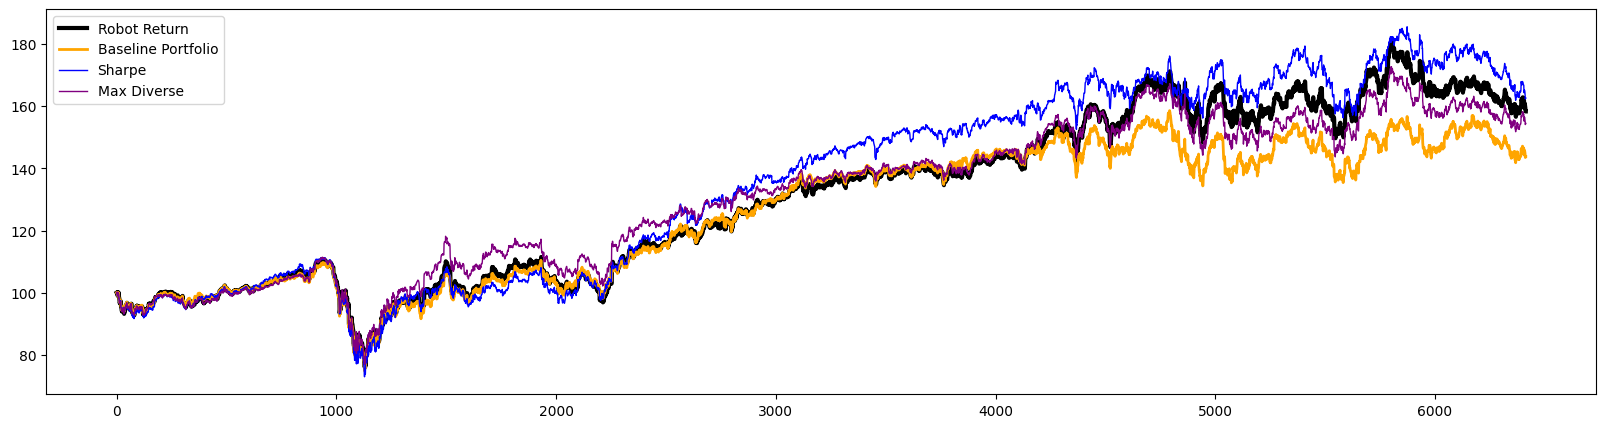

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(PPOrewardList,linewidth=3,color='black', label='Robot Return')
plt.plot(PPOunweightedRewardList,linewidth=2,color='orange',label='Baseline Portfolio')
plt.plot(PPOsharpeRewardList,linewidth=1,color='blue', label='Sharpe')
plt.plot(PPOmarkRewardList,linewidth=1,color='purple',label='Max Diverse')
plt.legend()
env.portfolio_diff

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
PPOrewardList2=[]
PPOunweightedRewardList2=[]
PPOsharpeRewardList2=[]
PPOmarkRewardList2=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=PPOmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  PPOrewardList2.append(test_env.net_worth)
  PPOunweightedRewardList2.append(test_env.even_net_worth)
  PPOsharpeRewardList2.append(test_env.sharpe_net_worth)
  PPOmarkRewardList2.append(test_env.mark_net_worth)

1.1059728858586857
159.07466195538973


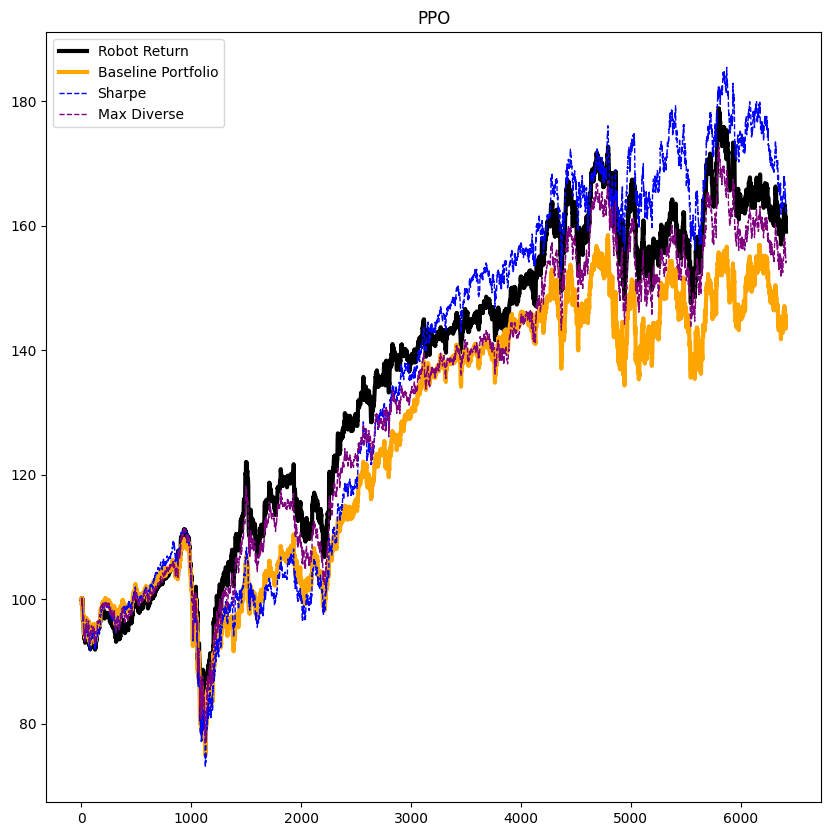

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(PPOrewardList2,linewidth=3,color='black', label='Robot Return')
plt.plot(PPOunweightedRewardList2,linewidth=3, color='orange',label='Baseline Portfolio')
plt.plot(PPOsharpeRewardList2,linewidth=1,color='blue',label='Sharpe',linestyle='dashed')
plt.plot(PPOmarkRewardList2,linewidth=1,color='purple',label='Max Diverse',linestyle='dashed')
plt.title('PPO')
plt.legend()
print(PPOrewardList2[-1]/PPOunweightedRewardList2[-1])
print(PPOrewardList2[-1])

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
PPOrewardList3=[]
PPOunweightedRewardList3=[]
PPOsharpeRewardList3=[]
PPOmarkRewardList3=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=PPOmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  PPOrewardList3.append(test_env.net_worth)
  PPOunweightedRewardList3.append(test_env.even_net_worth)
  PPOsharpeRewardList3.append(test_env.sharpe_net_worth)
  PPOmarkRewardList3.append(test_env.mark_net_worth)

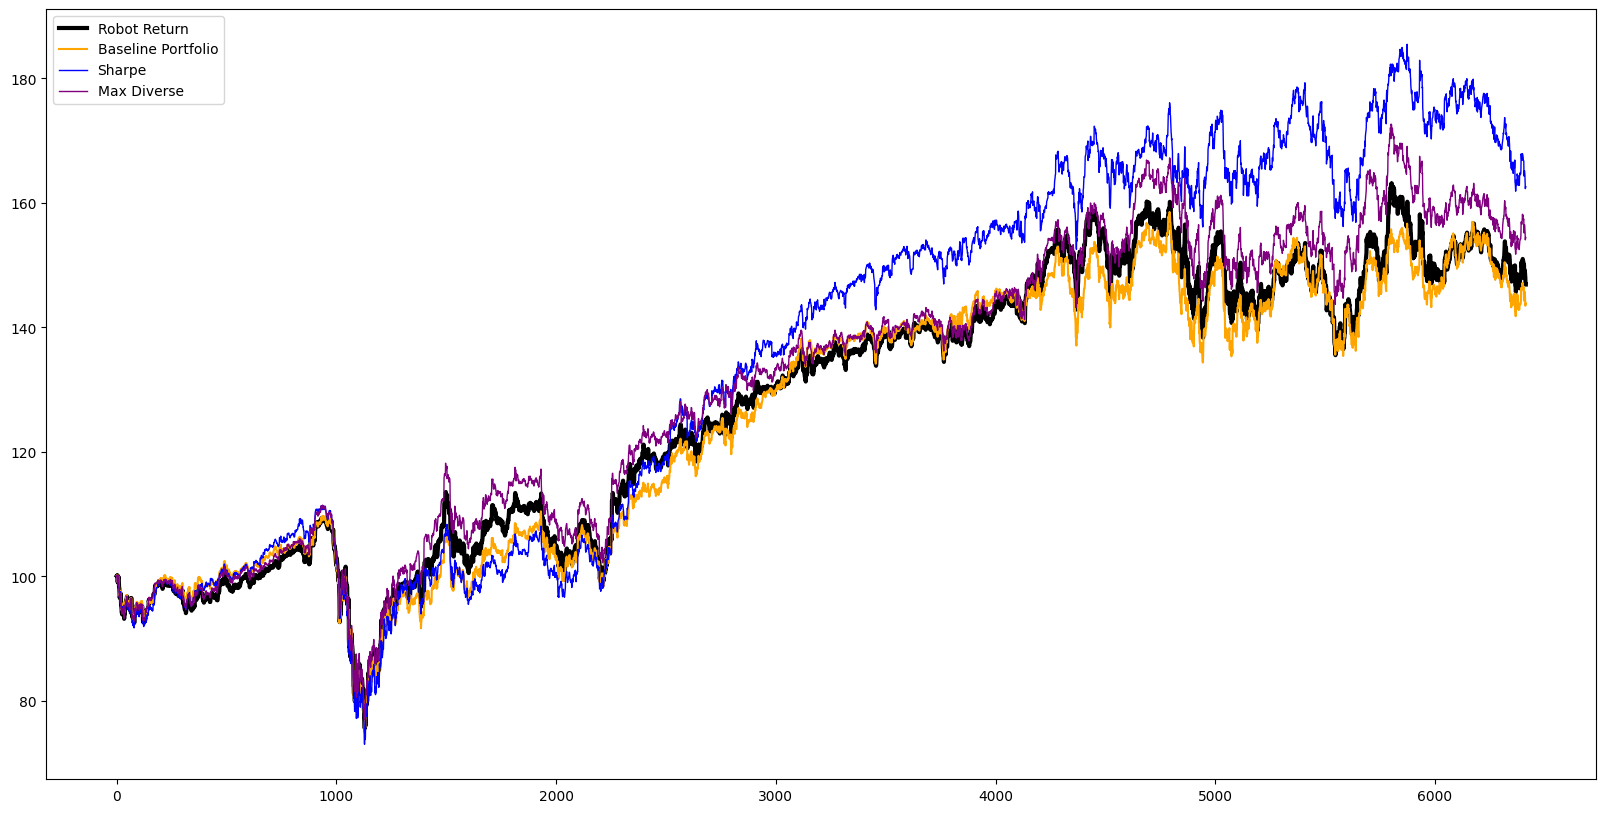

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(PPOrewardList3,linewidth=3,color='black', label='Robot Return')
plt.plot(PPOunweightedRewardList3,color='orange',label='Baseline Portfolio')
plt.plot(PPOsharpeRewardList3,linewidth=1,color='blue',label='Sharpe')
plt.plot(PPOmarkRewardList3,linewidth=1,color='purple',label='Max Diverse')
plt.legend()

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
PPOrewardList4=[]
PPOunweightedRewardList4=[]
PPOsharpeRewardList4=[]
PPOmarkRewardList4=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=PPOmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  PPOrewardList4.append(test_env.net_worth)
  PPOunweightedRewardList4.append(test_env.even_net_worth)
  PPOsharpeRewardList4.append(test_env.sharpe_net_worth)
  PPOmarkRewardList4.append(test_env.mark_net_worth)

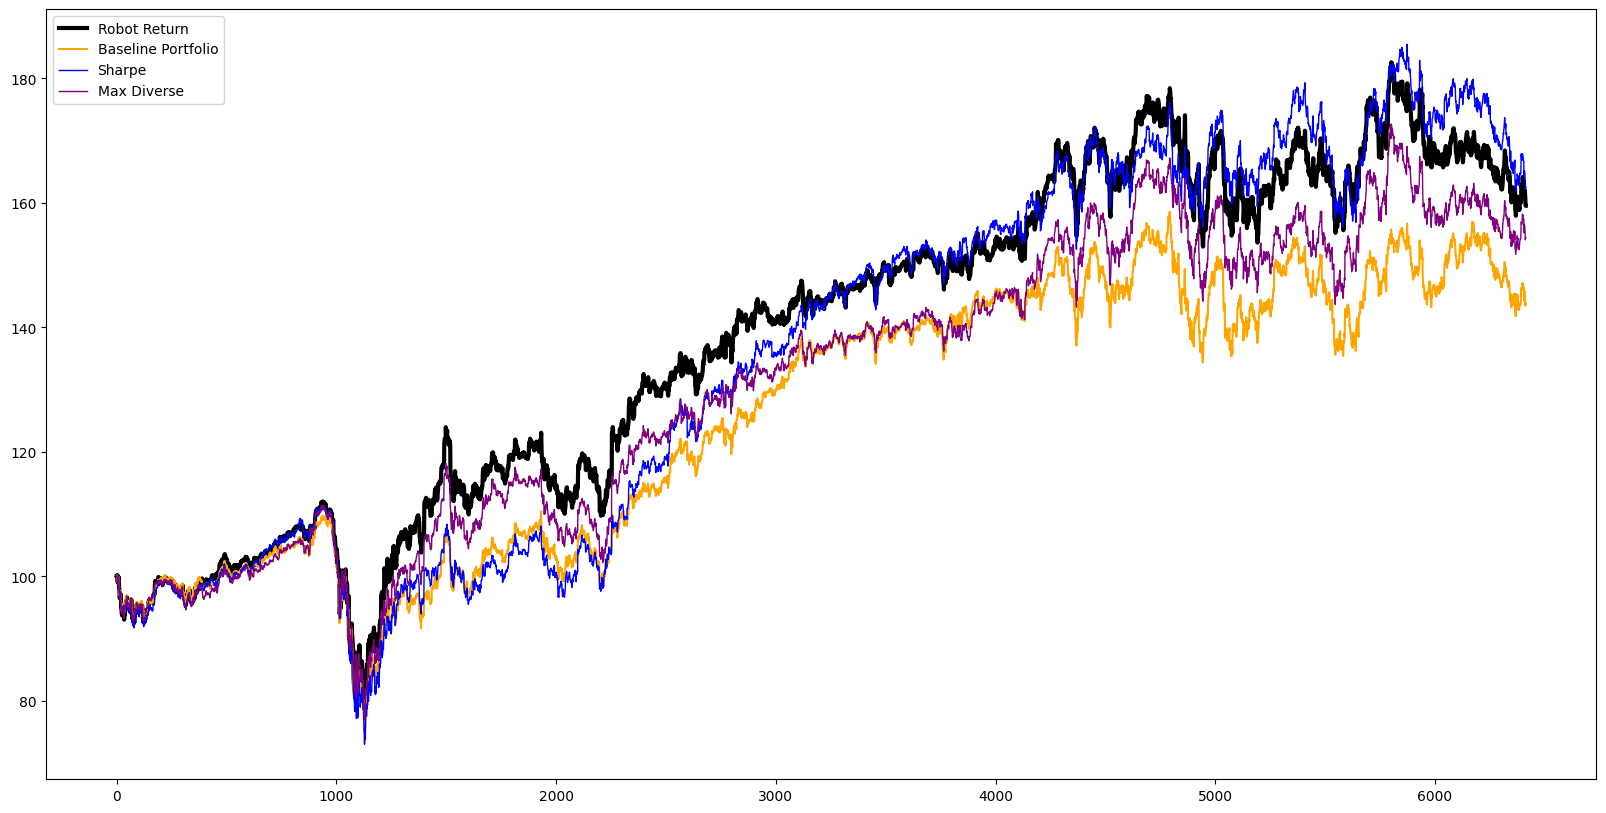

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(PPOrewardList4,linewidth=3,color='black', label='Robot Return')
plt.plot(PPOunweightedRewardList4,color='orange',label='Baseline Portfolio')
plt.plot(PPOsharpeRewardList4,linewidth=1,color='blue',label='Sharpe')
plt.plot(PPOmarkRewardList4,linewidth=1,color='purple',label='Max Diverse')
plt.legend()

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
PPOrewardList5=[]
PPOunweightedRewardList5=[]
PPOsharpeRewardList5=[]
PPOmarkRewardList5=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=PPOmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  PPOrewardList5.append(test_env.net_worth)
  PPOunweightedRewardList5.append(test_env.even_net_worth)
  PPOsharpeRewardList5.append(test_env.sharpe_net_worth)
  PPOmarkRewardList5.append(test_env.mark_net_worth)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(PPOrewardList5,linewidth=3, color='black', label='Robot Return')
plt.plot(PPOunweightedRewardList5,color='orange',label='Baseline Portfolio')
plt.plot(PPOsharpeRewardList5,linewidth=1,color='blue',label='Sharpe')
plt.plot(PPOmarkRewardList5,linewidth=1,color='purple',label='Max Diverse')
plt.legend()

In [ ]:
env=train_env(all_train,price_train,vol_train,sharpe_train,maxDiv_train)
env.reset()
#env.step(env.action_space.sample())
A2Cmodel = A2C('MlpPolicy', env, verbose=1)
A2Cmodel.learn(total_timesteps=50000)
print(env.reward,env.net_worth)
print(env.action1ct,env.action2ct,env.action3ct)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 403      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.546   |
|    explained_variance | 4.77e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.00351 |
|    value_loss         | 0.000153 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 388       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -0.38     |
|    explained_variance | -1.84e-05 |
|    learning_rate      | 0.0007    |
|    n_u

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
A2CrewardList=[]
A2CunweightedRewardList=[]
A2CsharpeRewardList=[]
A2CmarkRewardList=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=A2Cmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  A2CrewardList.append(test_env.net_worth)
  A2CunweightedRewardList.append(test_env.even_net_worth)
  A2CsharpeRewardList.append(test_env.sharpe_net_worth)
  A2CmarkRewardList.append(test_env.mark_net_worth)

1.1816260608100346
169.95603471336122


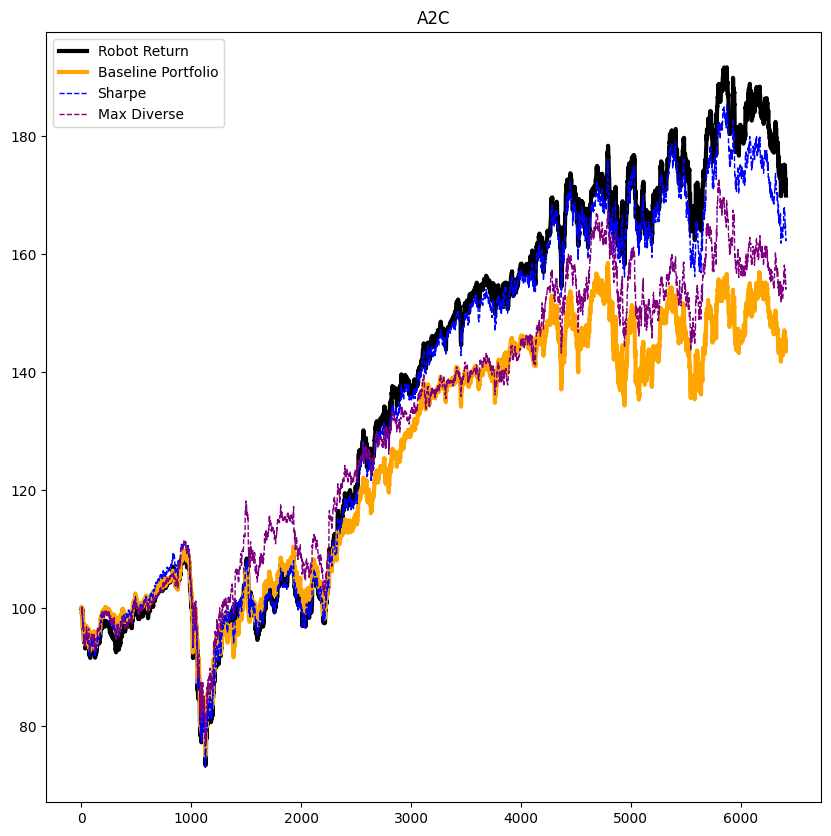

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(A2CrewardList,linewidth=3, color='black', label='Robot Return')
plt.plot(A2CunweightedRewardList,linewidth=3,color='orange',label='Baseline Portfolio')
plt.plot(A2CsharpeRewardList,linewidth=1,color='blue',label='Sharpe',linestyle='dashed')
plt.plot(A2CmarkRewardList,linewidth=1,color='purple',label='Max Diverse',linestyle='dashed')
plt.title('A2C')
plt.legend()
print(A2CrewardList[-1]/A2CunweightedRewardList[-1])
print(A2CrewardList[-1])

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
A2CrewardList2=[]
A2CunweightedRewardList2=[]
A2CsharpeRewardList2=[]
A2CmarkRewardList2=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=A2Cmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  A2CrewardList2.append(test_env.net_worth)
  A2CunweightedRewardList2.append(test_env.even_net_worth)
  A2CsharpeRewardList2.append(test_env.sharpe_net_worth)
  A2CmarkRewardList2.append(test_env.mark_net_worth)

1.0236098152361752


147.22818923945934

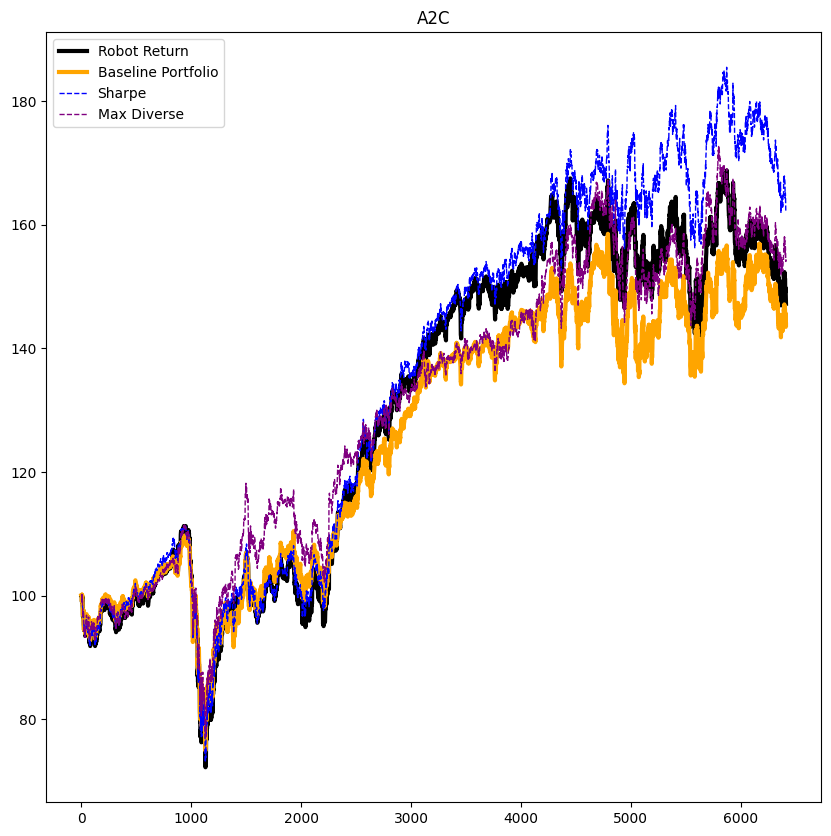

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(A2CrewardList2,linewidth=3, color='black', label='Robot Return')
plt.plot(A2CunweightedRewardList2,linewidth=3,color='orange',label='Baseline Portfolio')
plt.plot(A2CsharpeRewardList2,linewidth=1,color='blue',label='Sharpe',linestyle='dashed')
plt.plot(A2CmarkRewardList2,linewidth=1,color='purple',label='Max Diverse',linestyle='dashed')
plt.title('A2C')
plt.legend()
print(A2CrewardList2[-1]/A2CunweightedRewardList2[-1])
A2CrewardList2[-1]

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
A2CrewardList3=[]
A2CunweightedRewardList3=[]
A2CsharpeRewardList3=[]
A2CmarkRewardList3=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=A2Cmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  A2CrewardList3.append(test_env.net_worth)
  A2CunweightedRewardList3.append(test_env.even_net_worth)
  A2CsharpeRewardList3.append(test_env.sharpe_net_worth)
  A2CmarkRewardList3.append(test_env.mark_net_worth)

1.0656079058092651
153.26887264690023


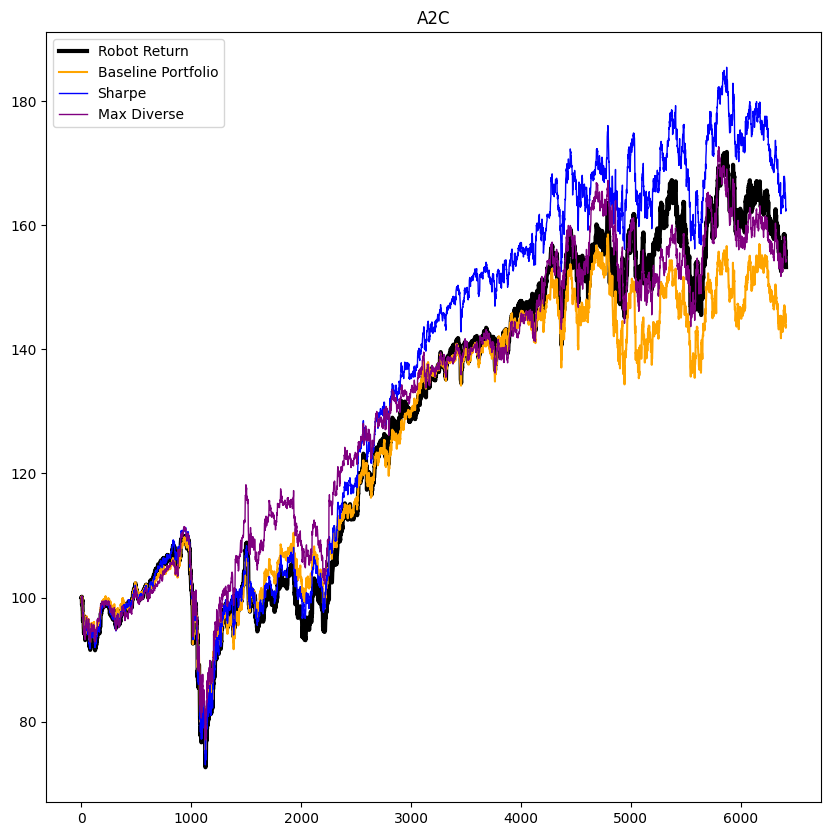

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(A2CrewardList3,linewidth=3, color='black', label='Robot Return')
plt.plot(A2CunweightedRewardList3,color='orange',label='Baseline Portfolio')
plt.plot(A2CsharpeRewardList3,linewidth=1,color='blue',label='Sharpe')
plt.plot(A2CmarkRewardList3,linewidth=1,color='purple',label='Max Diverse')
plt.legend()
plt.title('A2C')
plt.legend()
print(A2CrewardList3[-1]/A2CunweightedRewardList3[-1])
print(A2CrewardList3[-1])

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
A2CrewardList4=[]
A2CunweightedRewardList4=[]
A2CsharpeRewardList4=[]
A2CmarkRewardList4=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=A2Cmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  A2CrewardList4.append(test_env.net_worth)
  A2CunweightedRewardList4.append(test_env.even_net_worth)
  A2CsharpeRewardList4.append(test_env.sharpe_net_worth)
  A2CmarkRewardList4.append(test_env.mark_net_worth)

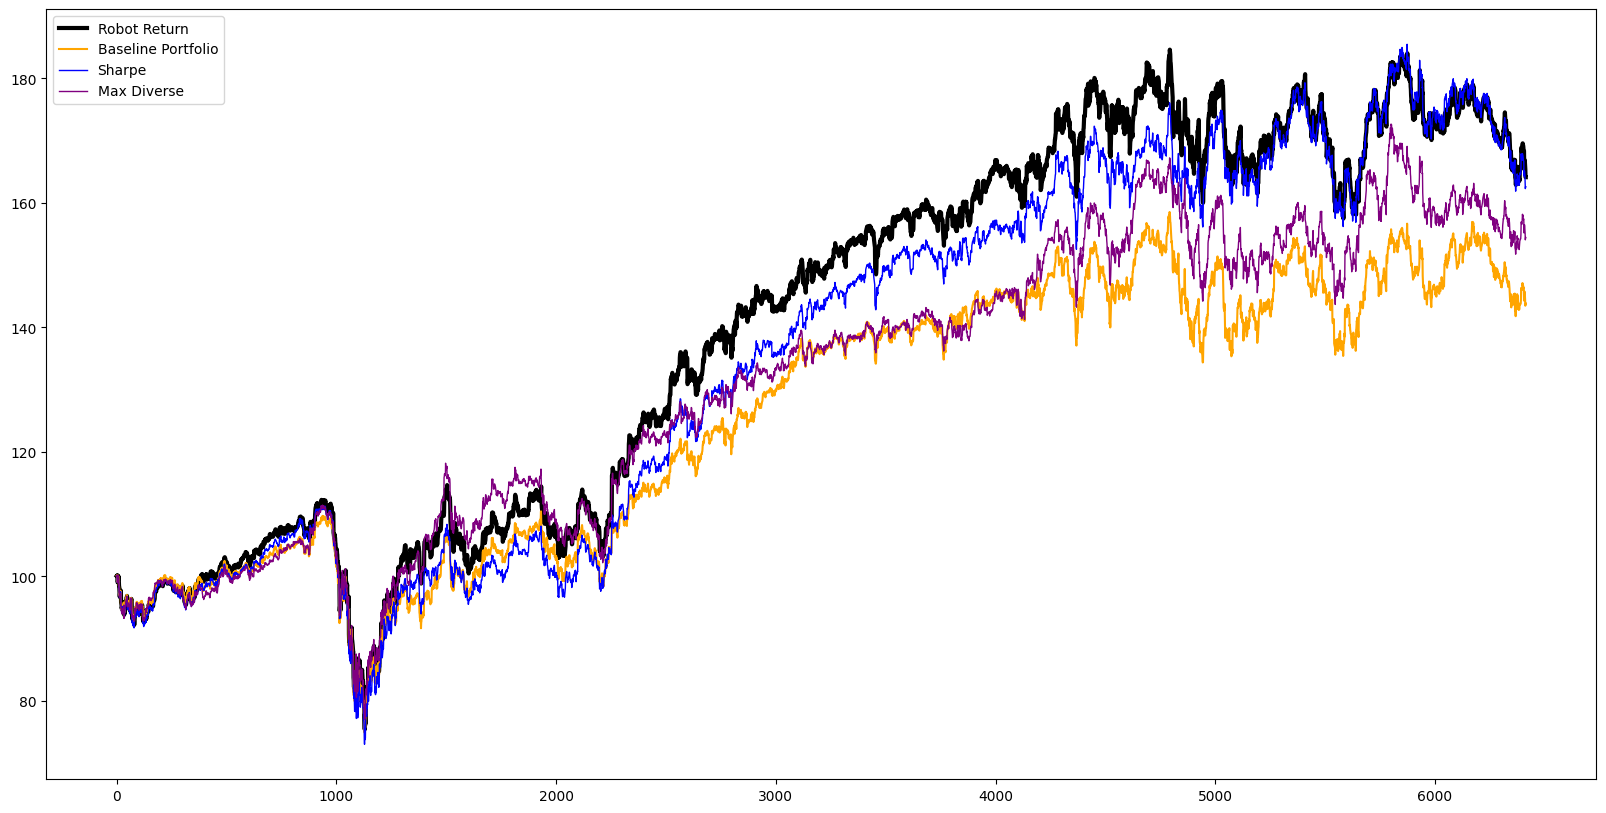

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(A2CrewardList4,linewidth=3, color='black', label='Robot Return')
plt.plot(A2CunweightedRewardList4,color='orange',label='Baseline Portfolio')
plt.plot(A2CsharpeRewardList4,linewidth=1,color='blue',label='Sharpe')
plt.plot(A2CmarkRewardList4,linewidth=1,color='purple',label='Max Diverse')
plt.legend()

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
A2CrewardList5=[]
A2CunweightedRewardList5=[]
A2CsharpeRewardList5=[]
A2CmarkRewardList5=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=A2Cmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  A2CrewardList5.append(test_env.net_worth)
  A2CunweightedRewardList5.append(test_env.even_net_worth)
  A2CsharpeRewardList5.append(test_env.sharpe_net_worth)
  A2CmarkRewardList5.append(test_env.mark_net_worth)

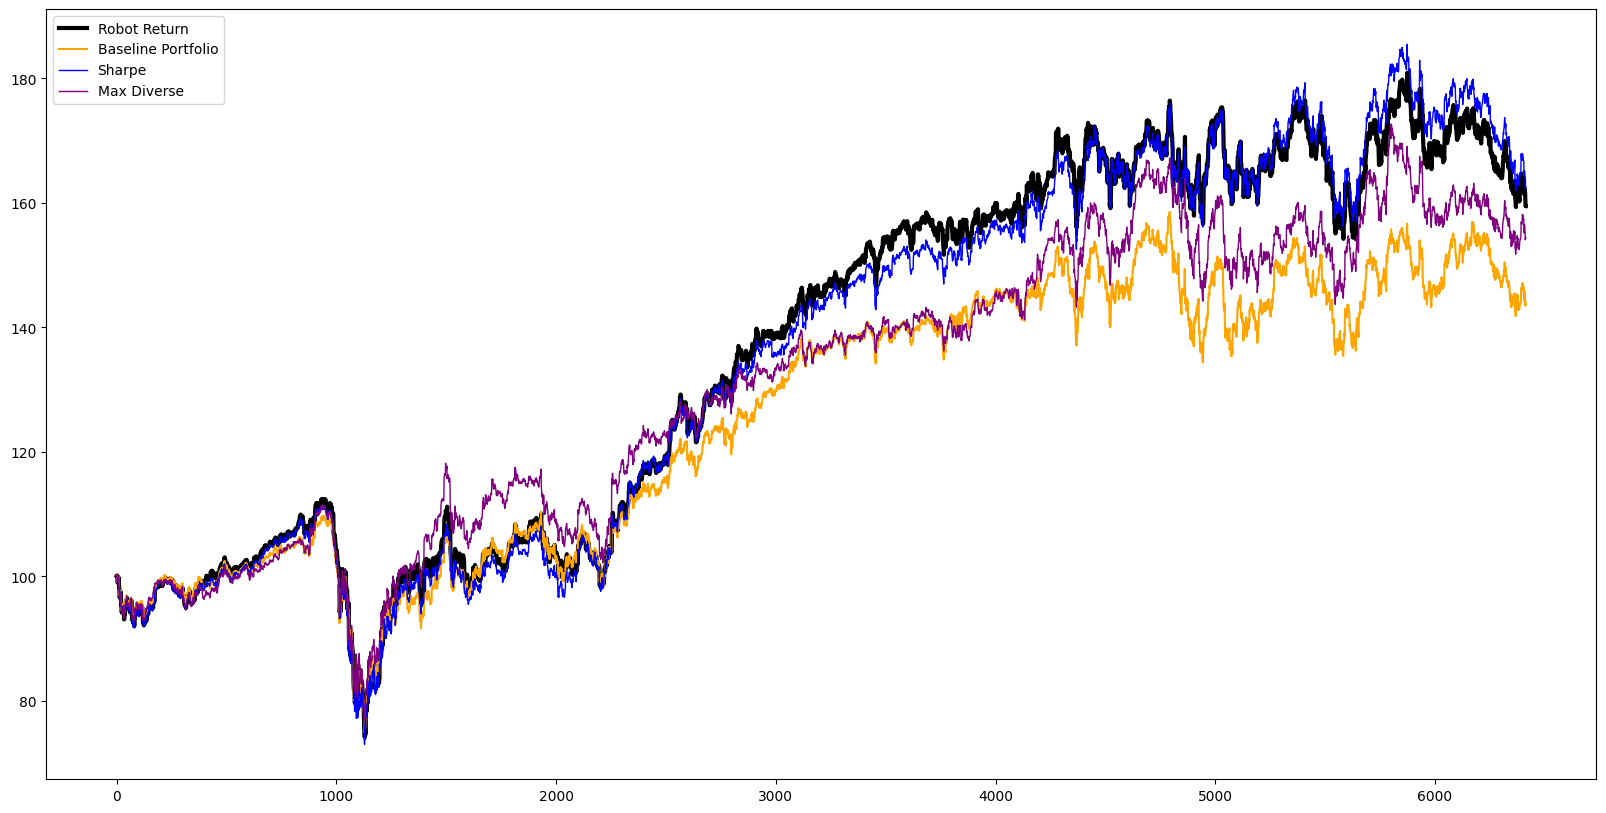

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(A2CrewardList5,linewidth=3, color='black', label='Robot Return')
plt.plot(A2CunweightedRewardList5,color='orange',label='Baseline Portfolio')
plt.plot(A2CsharpeRewardList5,linewidth=1,color='blue',label='Sharpe')
plt.plot(A2CmarkRewardList5,linewidth=1,color='purple',label='Max Diverse')
plt.legend()

In [ ]:
env=train_env(all_train,price_train,vol_train,sharpe_train,maxDiv_train)
env.reset()
#env.step(env.action_space.sample())
TRPOmodel = TRPO('MlpPolicy', env, verbose=1)
TRPOmodel.learn(total_timesteps=50000)
print(env.reward,env.net_worth)
print(env.action1ct,env.action2ct,env.action3ct)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 665  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                     |          |
|    fps                    | 607      |
|    iterations             | 2        |
|    time_elapsed           | 6        |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | 0.00658  |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00875  |
|    learning_rate          | 0.001    |
|    n_updates              | 1        |
|    policy_objective       | 0.0044   |
|    value_loss             | 0.00231  |
----------------------------------------
-----------------------------------------
| time/                     |          

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
TRPOrewardList=[]
TRPOunweightedRewardList=[]
TRPOsharpeRewardList=[]
TRPOmarkRewardList=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=TRPOmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  TRPOrewardList.append(test_env.net_worth)
  TRPOunweightedRewardList.append(test_env.even_net_worth)
  TRPOsharpeRewardList.append(test_env.sharpe_net_worth)
  TRPOmarkRewardList.append(test_env.mark_net_worth)

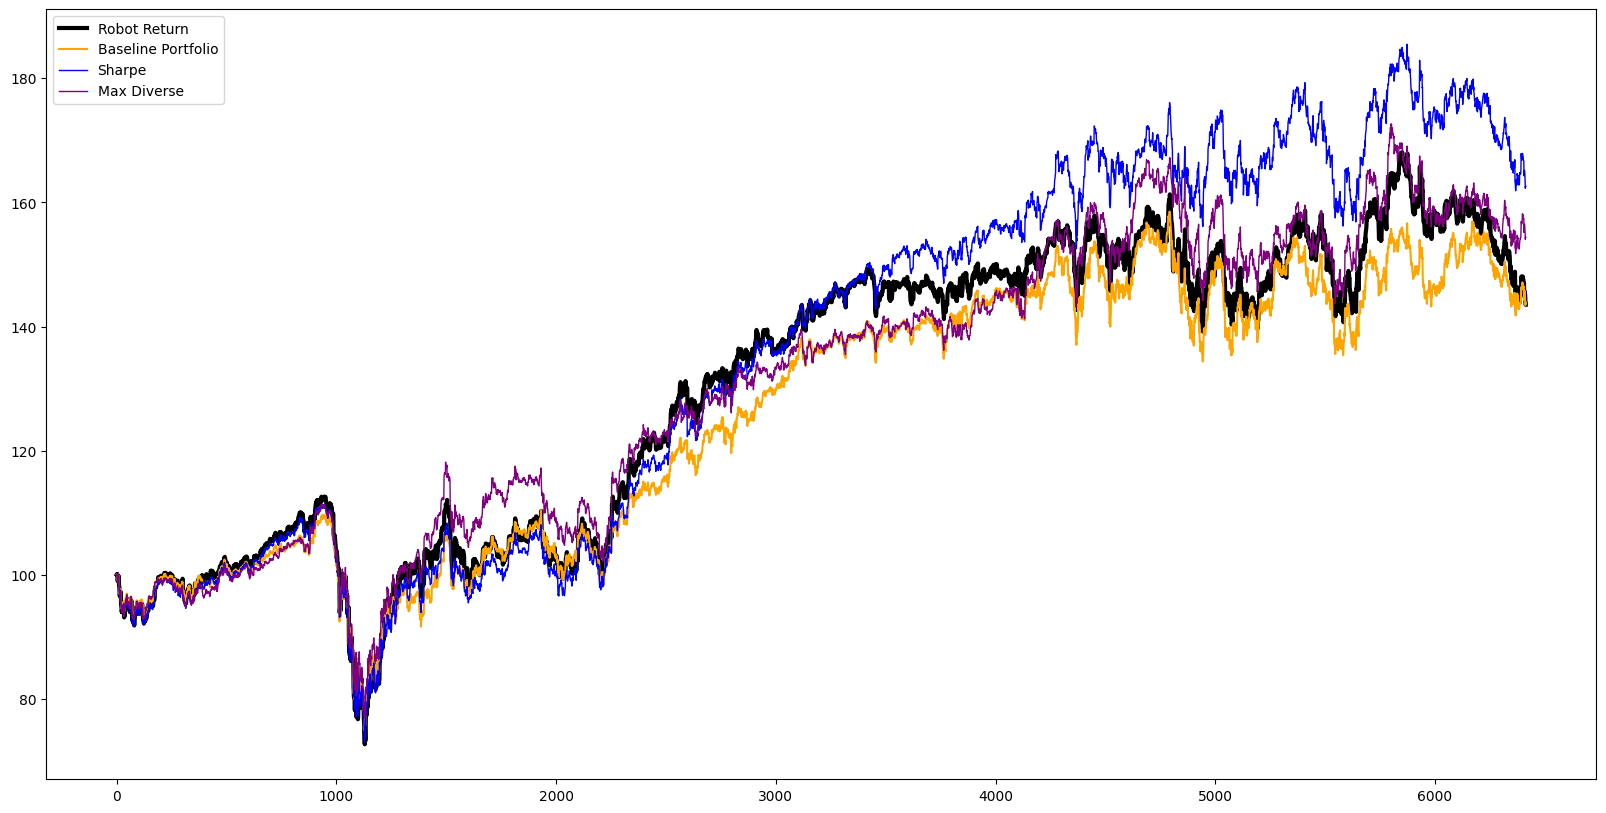

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(TRPOrewardList,linewidth=3, color='black', label='Robot Return')
plt.plot(TRPOunweightedRewardList,color='orange',label='Baseline Portfolio')
plt.plot(TRPOsharpeRewardList,linewidth=1,color='blue',label='Sharpe')
plt.plot(TRPOmarkRewardList,linewidth=1,color='purple',label='Max Diverse')
plt.legend()

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
TRPOrewardList2=[]
TRPOunweightedRewardList2=[]
TRPOsharpeRewardList2=[]
TRPOmarkRewardList2=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=TRPOmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  TRPOrewardList2.append(test_env.net_worth)
  TRPOunweightedRewardList2.append(test_env.even_net_worth)
  TRPOsharpeRewardList2.append(test_env.sharpe_net_worth)
  TRPOmarkRewardList2.append(test_env.mark_net_worth)

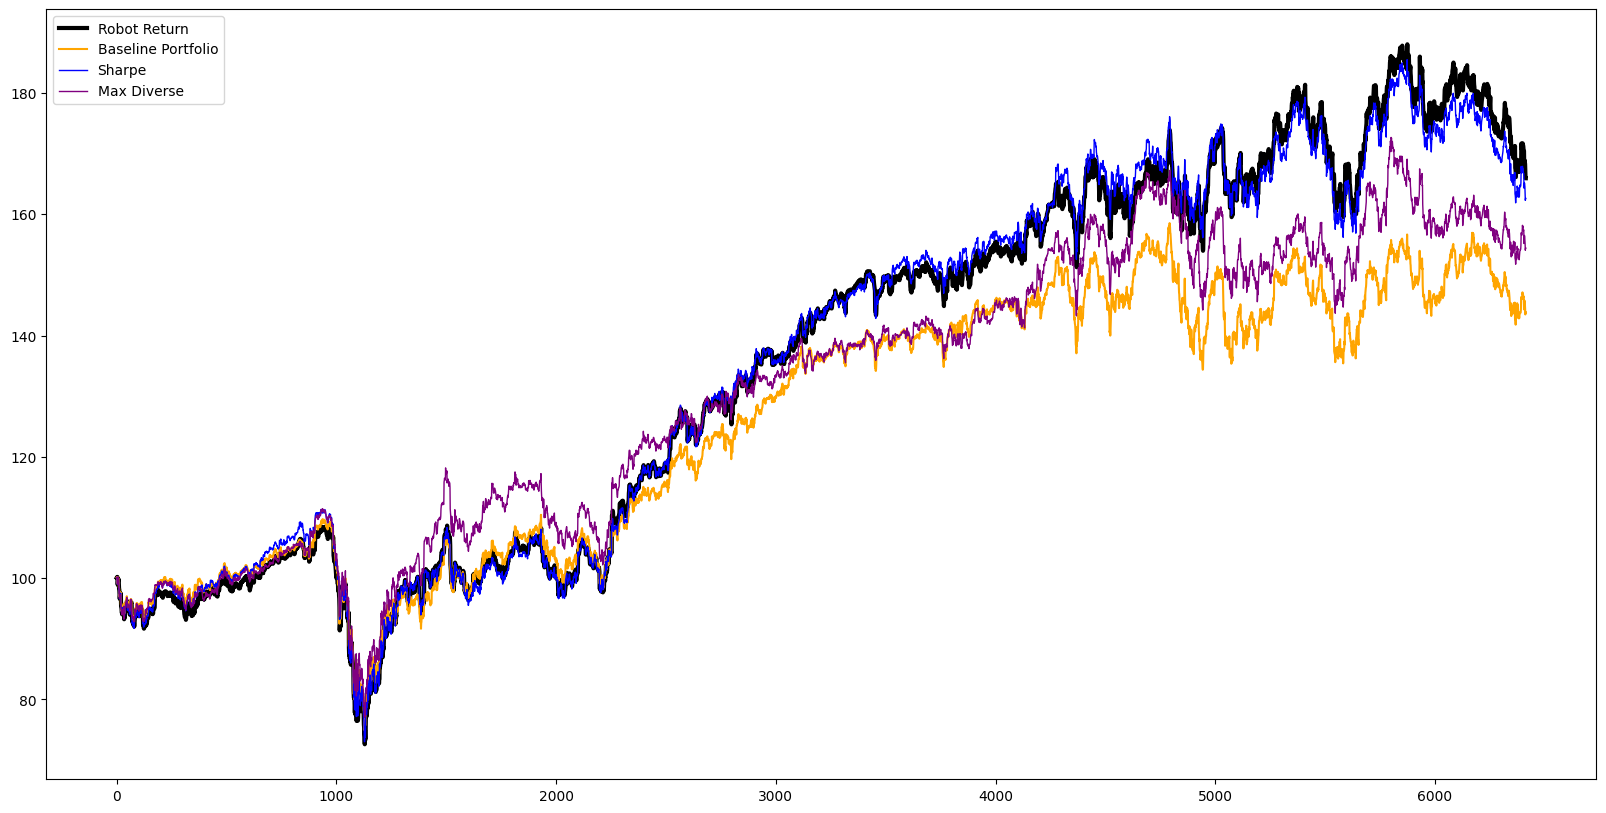

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(TRPOrewardList2,linewidth=3, color='black', label='Robot Return')
plt.plot(TRPOunweightedRewardList2,color='orange',label='Baseline Portfolio')
plt.plot(TRPOsharpeRewardList2,linewidth=1,color='blue',label='Sharpe')
plt.plot(TRPOmarkRewardList2,linewidth=1,color='purple',label='Max Diverse')
plt.legend()

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
TRPOrewardList3=[]
TRPOunweightedRewardList3=[]
TRPOsharpeRewardList3=[]
TRPOmarkRewardList3=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=TRPOmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  TRPOrewardList3.append(test_env.net_worth)
  TRPOunweightedRewardList3.append(test_env.even_net_worth)
  TRPOsharpeRewardList3.append(test_env.sharpe_net_worth)
  TRPOmarkRewardList3.append(test_env.mark_net_worth)

In [ ]:
ppoMean=np.sum([PPOrewardList[-1],PPOrewardList2[-1],PPOrewardList3[-1],PPOrewardList4[-1],PPOrewardList5[-1]])/5
print(ppoMean)
print(ppoMean/PPOunweightedRewardList[-1])
a2cMean=np.sum([A2CrewardList[-1],A2CrewardList2[-1],A2CrewardList3[-1],A2CrewardList4[-1],A2CrewardList5[-1]])/5
print(a2cMean)
print(a2cMean/A2CunweightedRewardList[-1])
trpMean=np.sum([TRPOrewardList[-1],TRPOrewardList2[-1],TRPOrewardList3[-1],TRPOrewardList4[-1],TRPOrewardList5[-1]])/5
print(trpMean)
print(trpMean/TRPOunweightedRewardList[-1])

156.42648648346344
1.0875613410347347
158.80923731858374
1.1041275105617157
163.1824711996582
1.1345325922795275


1.2130961347693605
1.0731048766968256
174.4824489146498


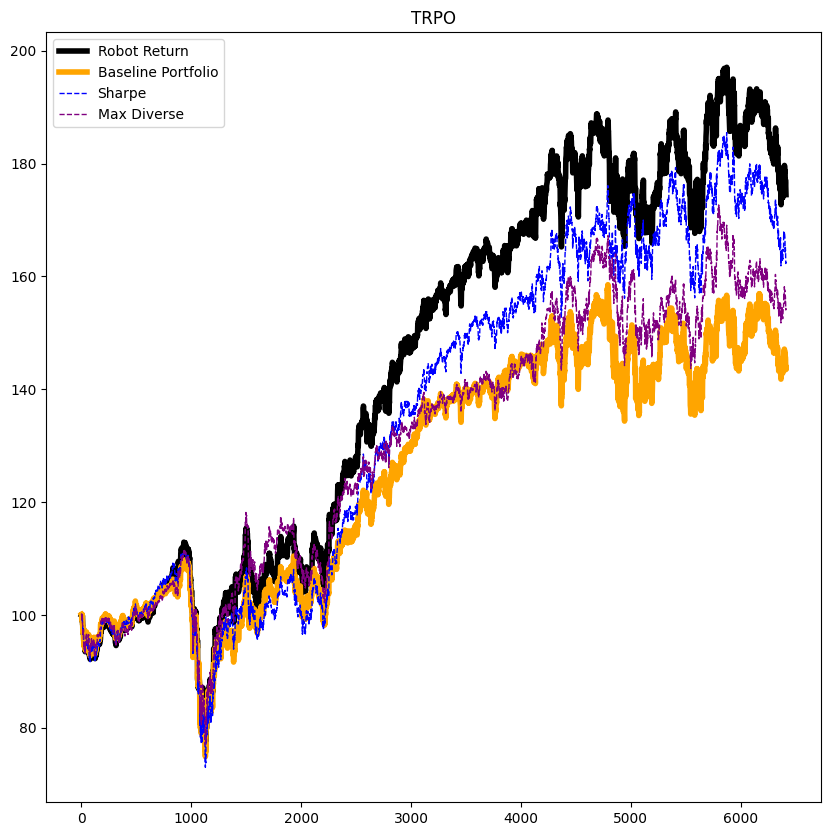

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(TRPOrewardList3,linewidth=4, color='black', label='Robot Return')
plt.plot(TRPOunweightedRewardList3,linewidth=4,color='orange',label='Baseline Portfolio')
plt.plot(TRPOsharpeRewardList3,linewidth=1,color='blue',label='Sharpe',linestyle='dashed')
plt.plot(TRPOmarkRewardList3,linewidth=1,color='purple',label='Max Diverse',linestyle='dashed')
plt.title('TRPO')
plt.legend()
print(TRPOrewardList3[-1]/TRPOunweightedRewardList3[-1])
print(TRPOrewardList3[-1]/TRPOsharpeRewardList3[-1])
print(TRPOrewardList3[-1])

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
TRPOrewardList4=[]
TRPOunweightedRewardList4=[]
TRPOsharpeRewardList4=[]
TRPOmarkRewardList4=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=TRPOmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  TRPOrewardList4.append(test_env.net_worth)
  TRPOunweightedRewardList4.append(test_env.even_net_worth)
  TRPOsharpeRewardList4.append(test_env.sharpe_net_worth)
  TRPOmarkRewardList4.append(test_env.mark_net_worth)

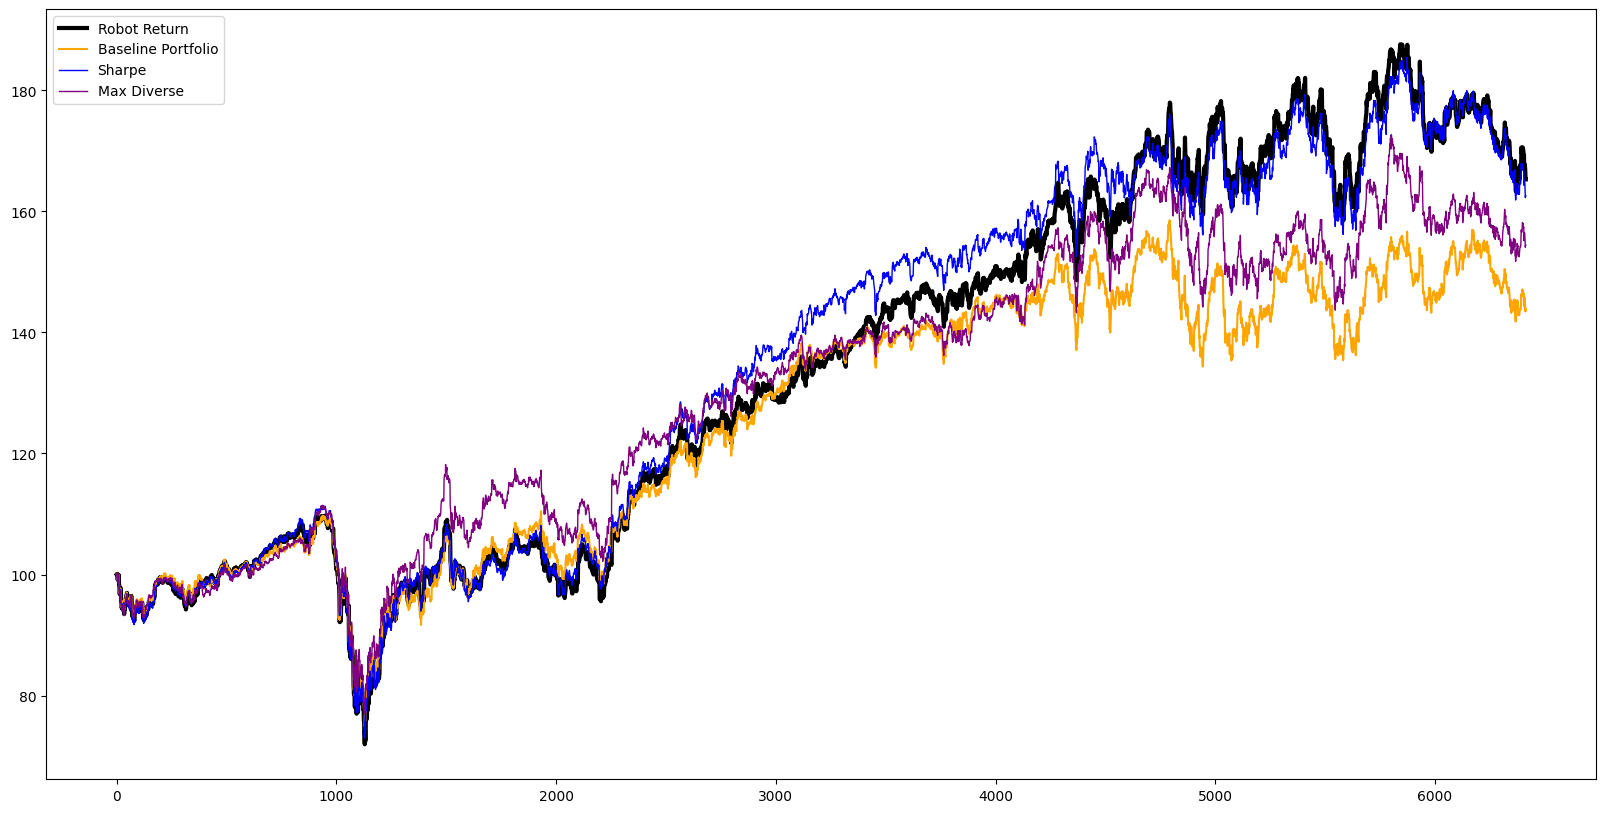

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(TRPOrewardList4,linewidth=3, color='black', label='Robot Return')
plt.plot(TRPOunweightedRewardList4,color='orange',label='Baseline Portfolio')
plt.plot(TRPOsharpeRewardList4,linewidth=1,color='blue',label='Sharpe')
plt.plot(TRPOmarkRewardList4,linewidth=1,color='purple',label='Max Diverse')
plt.legend()

In [ ]:
test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
episodes = 1
TRPOrewardList5=[]
TRPOunweightedRewardList5=[]
TRPOsharpeRewardList5=[]
TRPOmarkRewardList5=[]
test_env.reset()
obvs=test_env.reset()
done=False
while done == False:
  action,_states=TRPOmodel.predict(obvs)
  obvs,rewards,done,info=test_env.step(action)
  #print('NW',test_env.net_worth)
  TRPOrewardList5.append(test_env.net_worth)
  TRPOunweightedRewardList5.append(test_env.even_net_worth)
  TRPOsharpeRewardList5.append(test_env.sharpe_net_worth)
  TRPOmarkRewardList5.append(test_env.mark_net_worth)

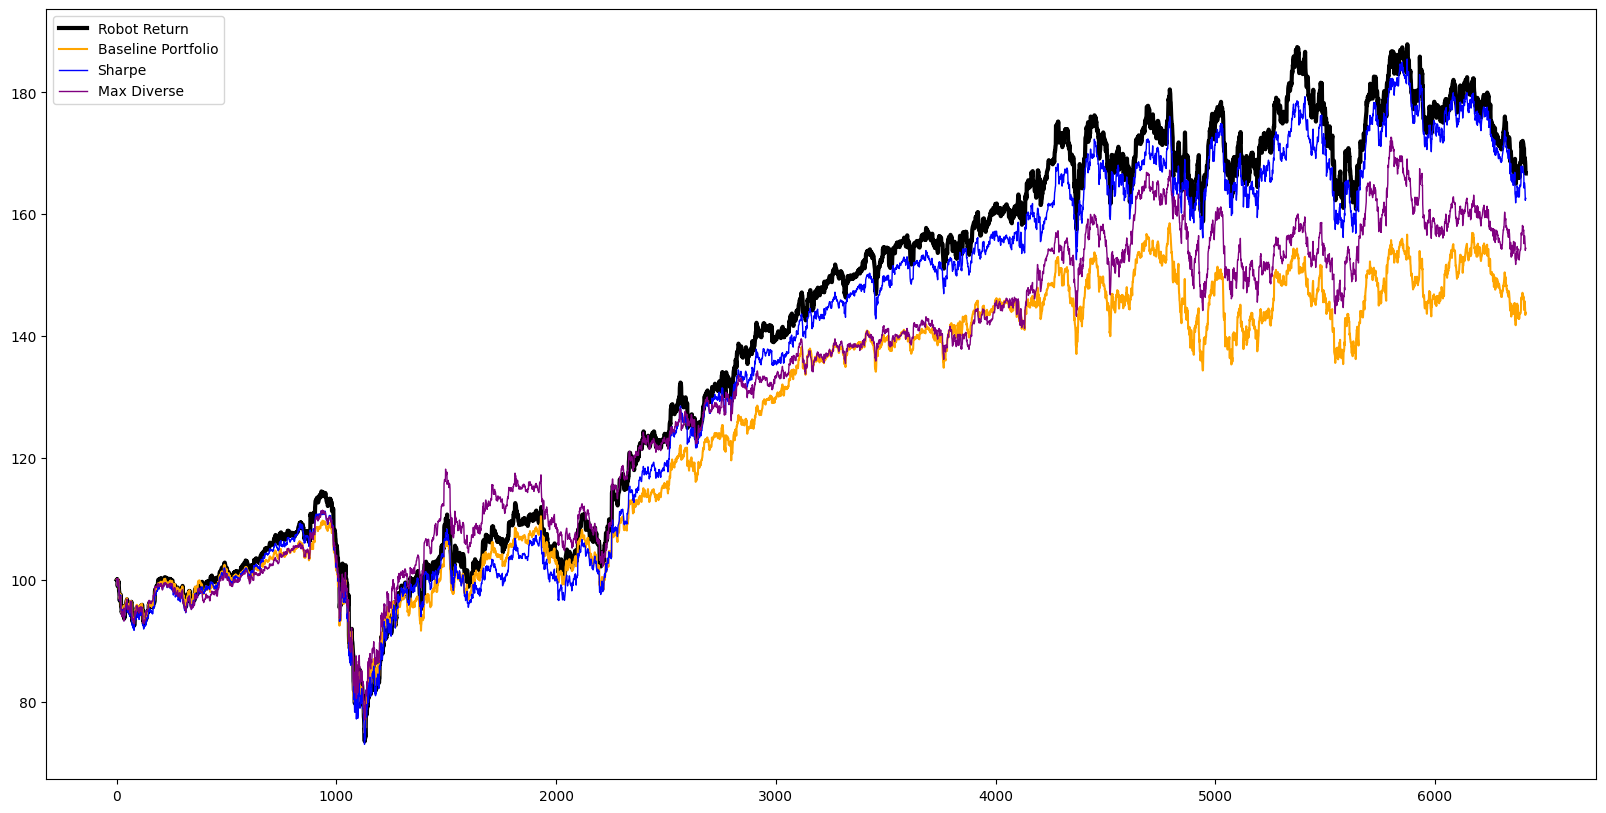

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(TRPOrewardList5,linewidth=3, color='black', label='Robot Return')
plt.plot(TRPOunweightedRewardList5,color='orange',label='Baseline Portfolio')
plt.plot(TRPOsharpeRewardList5,linewidth=1,color='blue',label='Sharpe')
plt.plot(TRPOmarkRewardList5,linewidth=1,color='purple',label='Max Diverse')
plt.legend()

## Increasing to 100,000 training steps

This is equivalent to iterating over the training data approximately four times.  Increasing too far beyond this point seems to result in overfitting.

In [ ]:
env=train_env(all_train,price_train,vol_train,sharpe_train,maxDiv_train)
env.reset()
#env.step(env.action_space.sample())
PPOmodel2 = PPO('MlpPolicy', env, verbose=1)
PPOmodel2.learn(total_timesteps=100000)
print(env.reward,env.net_worth)
print(env.action1ct,env.action2ct,env.action3ct)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 674  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 463         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018512916 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.678      |
|    explained_variance   | 0.0328      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0134     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00335    |
|    value_loss         

In [ ]:
ppo2list=[]
for i in range(5):
  test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
  PPO2rewardList=[]
  PPO2unweightedRewardList=[]
  PPO2sharpeRewardList=[]
  PPO2markRewardList=[]
  test_env.reset()
  obvs=test_env.reset()
  done=False
  while done == False:
    action,_states=PPOmodel2.predict(obvs)
    obvs,rewards,done,info=test_env.step(action)
    #print('NW',test_env.net_worth)
    PPO2rewardList.append(test_env.net_worth)
    PPO2unweightedRewardList.append(test_env.even_net_worth)
    PPO2sharpeRewardList.append(test_env.sharpe_net_worth)
    PPO2markRewardList.append(test_env.mark_net_worth)
  ppo2list.append([PPO2rewardList,PPO2unweightedRewardList,PPO2sharpeRewardList,PPO2markRewardList])

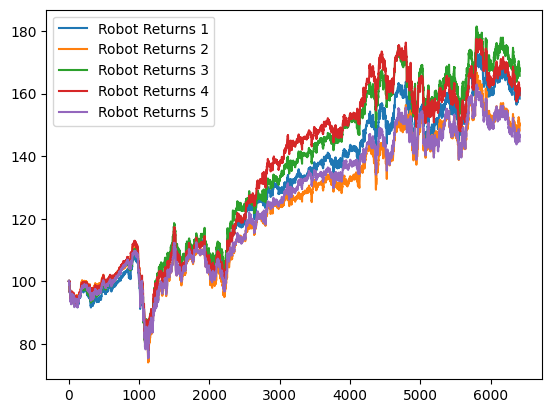

In [ ]:
plt.plot(ppo2list[0][0],label='Robot Returns 1')
plt.plot(ppo2list[1][0],label='Robot Returns 2')
plt.plot(ppo2list[2][0],label='Robot Returns 3')
plt.plot(ppo2list[3][0],label='Robot Returns 4')
plt.plot(ppo2list[4][0],label='Robot Returns 5')
plt.legend()

In [ ]:
env=train_env(all_train,price_train,vol_train,sharpe_train,maxDiv_train)
env.reset()
#env.step(env.action_space.sample())
A2Cmodel2 = A2C('MlpPolicy', env, verbose=1)
A2Cmodel2.learn(total_timesteps=100000)
print(env.reward,env.net_worth)
print(env.action1ct,env.action2ct,env.action3ct)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| time/                 |           |
|    fps                | 319       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.689    |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -0.000632 |
|    value_loss         | 7.69e-06  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 332      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.682   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|   

In [ ]:
a2c2list=[]
for i in range(5):
  test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
  A2C2rewardList=[]
  A2C2unweightedRewardList=[]
  A2C2sharpeRewardList=[]
  A2C2markRewardList=[]
  test_env.reset()
  obvs=test_env.reset()
  done=False
  while done == False:
    action,_states=A2Cmodel2.predict(obvs)
    obvs,rewards,done,info=test_env.step(action)
    #print('NW',test_env.net_worth)
    A2C2rewardList.append(test_env.net_worth)
    A2C2unweightedRewardList.append(test_env.even_net_worth)
    A2C2sharpeRewardList.append(test_env.sharpe_net_worth)
    A2C2markRewardList.append(test_env.mark_net_worth)
  a2c2list.append([A2C2rewardList,A2C2unweightedRewardList,A2C2sharpeRewardList,A2C2markRewardList])

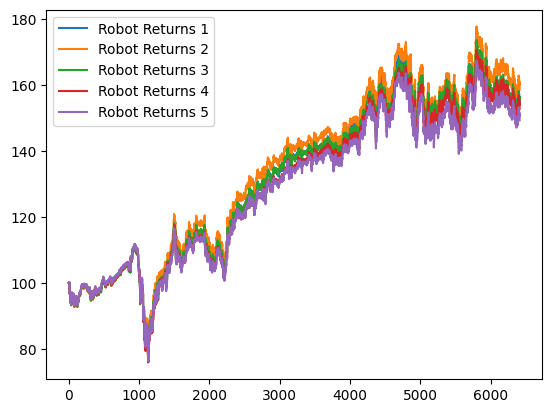

In [ ]:
plt.plot(a2c2list[0][0],label='Robot Returns 1')
plt.plot(a2c2list[1][0],label='Robot Returns 2')
plt.plot(a2c2list[2][0],label='Robot Returns 3')
plt.plot(a2c2list[3][0],label='Robot Returns 4')
plt.plot(a2c2list[4][0],label='Robot Returns 5')
plt.legend()

In [ ]:
env=train_env(all_train,price_train,vol_train,sharpe_train,maxDiv_train)
env.reset()
#env.step(env.action_space.sample())
TRPOmodel2 = TRPO('MlpPolicy', env, verbose=1)
TRPOmodel2.learn(total_timesteps=100000)
print(env.reward,env.net_worth)
print(env.action1ct,env.action2ct,env.action3ct)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 519  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                     |          |
|    fps                    | 559      |
|    iterations             | 2        |
|    time_elapsed           | 7        |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | 0        |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.0098   |
|    learning_rate          | 0.001    |
|    n_updates              | 1        |
|    policy_objective       | 0.00087  |
|    value_loss             | 0.00064  |
----------------------------------------
----------------------------------------
| time/                     |          |

In [ ]:
trpo2list=[]
for i in range(5):
  test_env=train_env(all_test,price_test,vol_test,sharpe_test,maxDiv_test)
  TRPO2rewardList=[]
  TRPO2unweightedRewardList=[]
  TRPO2sharpeRewardList=[]
  TRPO2markRewardList=[]
  test_env.reset()
  obvs=test_env.reset()
  done=False
  while done == False:
    action,_states=TRPOmodel2.predict(obvs)
    obvs,rewards,done,info=test_env.step(action)
    #print('NW',test_env.net_worth)
    TRPO2rewardList.append(test_env.net_worth)
    TRPO2unweightedRewardList.append(test_env.even_net_worth)
    TRPO2sharpeRewardList.append(test_env.sharpe_net_worth)
    TRPO2markRewardList.append(test_env.mark_net_worth)
  subList=[TRPO2rewardList,TRPO2unweightedRewardList,TRPO2sharpeRewardList,TRPO2markRewardList]
  trpo2list.append(subList)

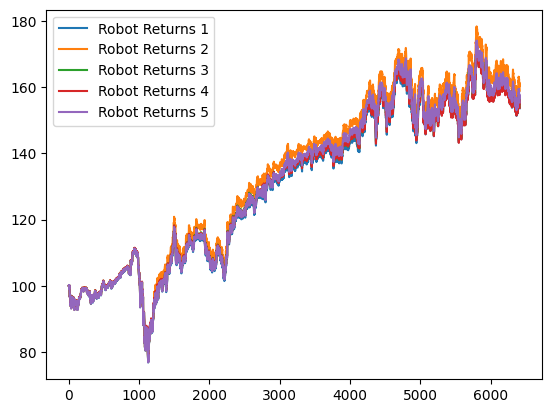

In [ ]:
plt.plot(trpo2list[0][0],label='Robot Returns 1')
plt.plot(trpo2list[1][0],label='Robot Returns 2')
plt.plot(trpo2list[2][0],label='Robot Returns 3')
plt.plot(trpo2list[3][0],label='Robot Returns 4')
plt.plot(trpo2list[4][0],label='Robot Returns 5')
plt.legend()

# Results and Discussion
Running the models on two iterations of the training dataset yielded better results than four iterations.  This is as expected - repeating the same data too many times results in overfitting.

A common problem across all model types seems to be that they tend to cling to one action choice or the other as soon as they begin to get consistent positive rewards from it.  This results in many test graphs where the model performance tracks closely to one of the two portfolio metrics.  This could probably be dealt with by increasing the amount of forced error or randomness in the model's choices. 

All models performed well compared to the baseline and the SP500 over an equivalent timeframe.  The true desired outcome, however, is to have the model outperform both portfolio metrics by combining knowledge from each technique and learning how to situationally apply the optimal action - it is not impressive to build a complex model that can be outperformed by simpler methods.

TRPO with 50,000 iterations was the only model to achieve this consistently during the tests ran - an example test iteration is shown below.  This specific iteration outperforms the baseline by 21.3% and, more significantly, outperforms the Sharpe portfolio metric by 7.3%.  I consider this a successful outcome within the context of this project.

Further steps are to experiment with different portfolio assets, tweak the model hyperparameters to encourage more exploration, and expand the amount and diversity of market data tested on. 

1.2130961347693605
1.0731048766968256


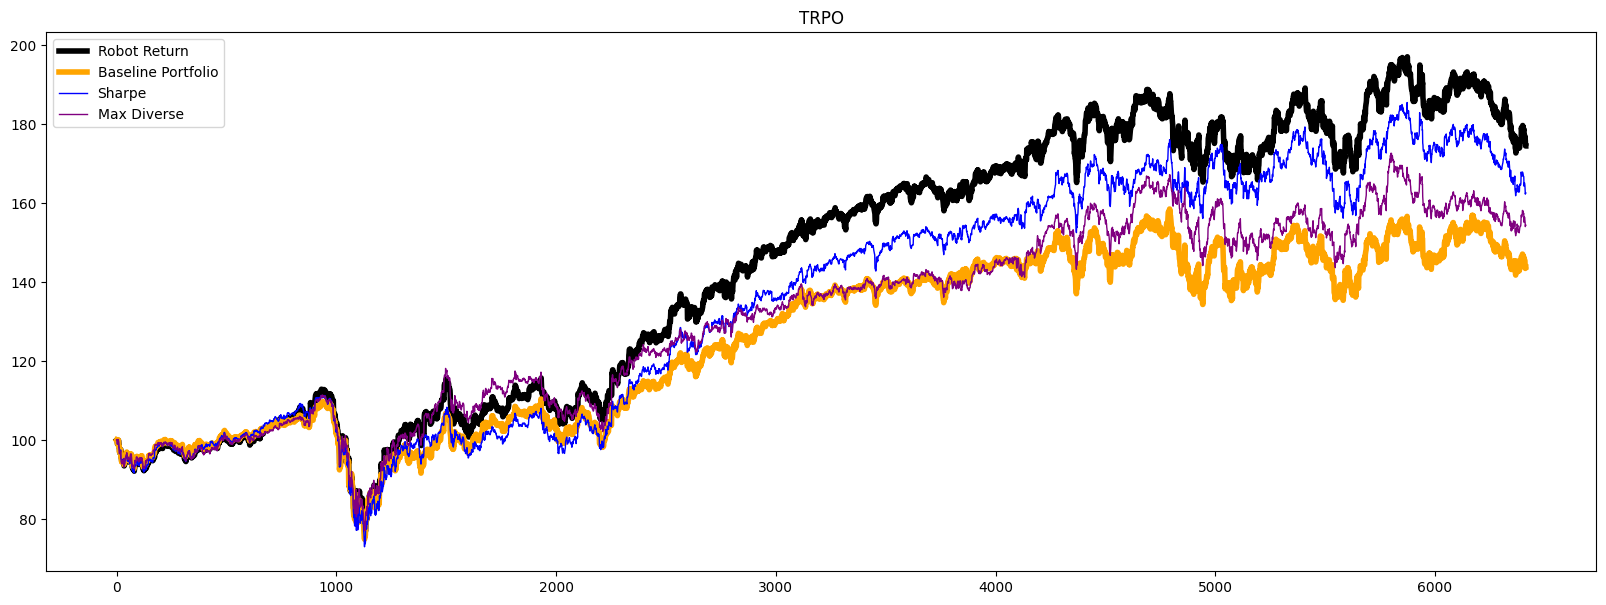

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(TRPOrewardList3,linewidth=4, color='black', label='Robot Return')
plt.plot(TRPOunweightedRewardList3,linewidth=4,color='orange',label='Baseline Portfolio')
plt.plot(TRPOsharpeRewardList3,linewidth=1,color='blue',label='Sharpe')
plt.plot(TRPOmarkRewardList3,linewidth=1,color='purple',label='Max Diverse')
plt.title('TRPO')
plt.legend()
print(TRPOrewardList3[-1]/TRPOunweightedRewardList3[-1])
print(TRPOrewardList3[-1]/TRPOsharpeRewardList3[-1])